# Observations of the heat budget of coastal Arctic sea ice under the influence of a river outflow

Master analysis notebook for this Ikaagvik Sikukuun paper.


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import cartopy.crs as ccrs
import cartopy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
from osgeo import gdal, osr
import gsw
import windrose
import warnings
import pickle
import tqdm

from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import colorcet as cc
%matplotlib inline

%load_ext autoreload
%autoreload



C:\Users\cwitt\Anaconda3\lib\site-packages\windrose\windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
C:\Users\cwitt\Anaconda3\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\cwitt\Anaconda3\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\cwitt\Anaconda3\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc

## Figure 1: Layered Sea Ice Cover Map

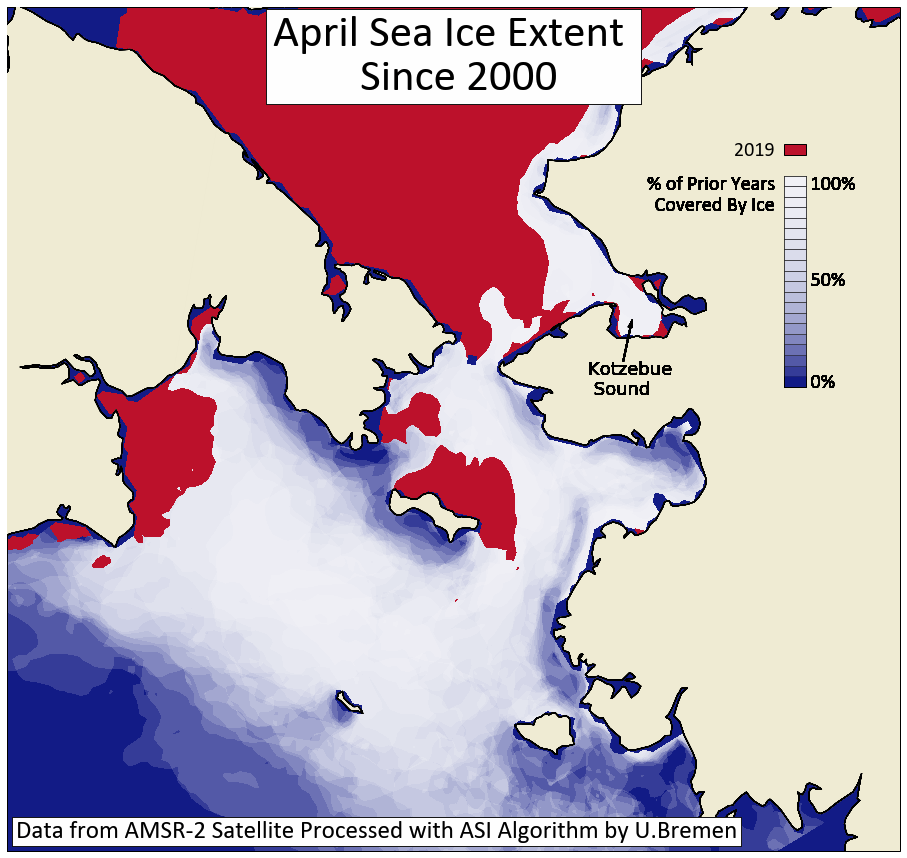

In [3]:
#open datasets of sea ice cover in Bering Strait region for 2000-2018 and 2019 (see Appendix 1 for how I got these datasets)
si = xr.open_dataset('../../Data/Satellite/Sea Ice/ASI_SSMI/si_2000_2018.nc')
si19 = xr.open_dataset('../../Data/Satellite/Sea Ice/ASI_SSMI/si_2019.nc')

#generate map of transparent sea ice cover + 2019 overlaid in red
from Satellite_SeaIce_Toolbox import plot_layered_ice_map
plot_layered_ice_map(si = si, 
                     si19 = si19, 
                     startDay = 91,       #first yearday of April 
                     endDay = 120,        #last yearday of April 
                     thresh = 70,         #minimum sea ice cover threshold to plot as "covered"
                     transparency = 0.15, #transparency of each layer. 0.15 will make a 100% value be about 96% opaque
                     plotflag = 1)        #set to 1 if you want to save figures for every year as it is added

plt.savefig('Figures/Layered Sea Ice Maps/AprSeaIceExtent_to_2019_v2.png',dpi=300,facecolor='w')

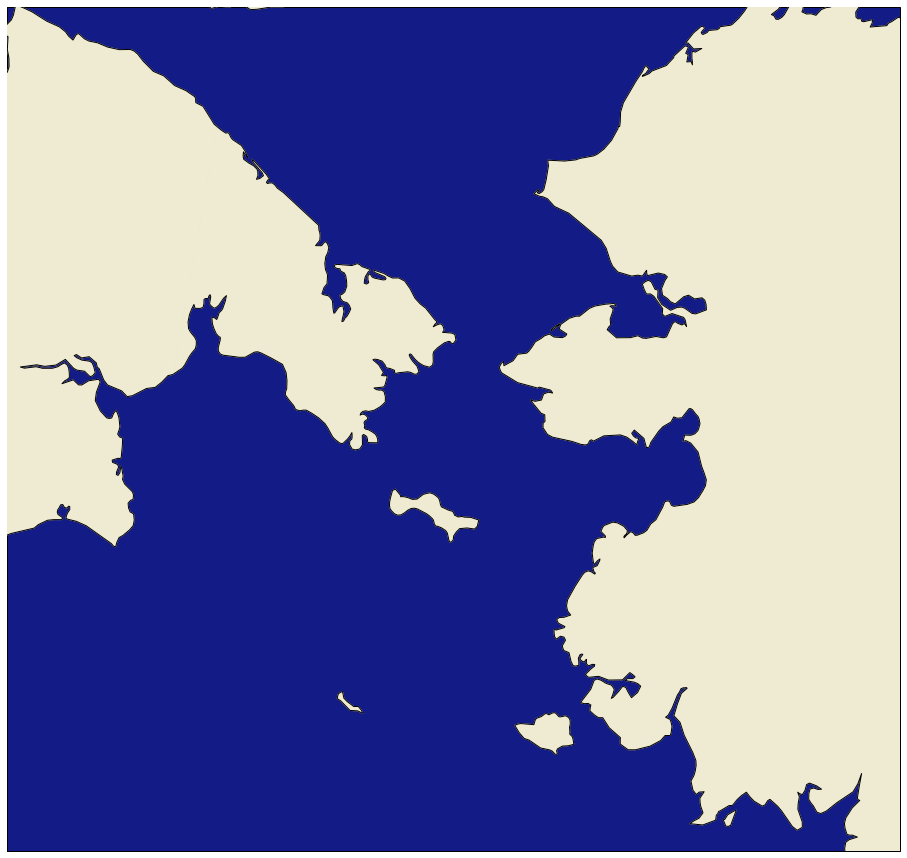

In [10]:
#generate map of just the background
#initialize plotting variables
lon_min, lon_max = 175, -150
lat_min, lat_max = 58, 75
xmin, xmax = lon_min+2.5, lon_max-6 #map limits, tuned for nice plot
ymin, ymax = lat_min-0.1, lat_max-4.25 #map limits, tuned for nice plot
cmax = 100

color2019='#bc112b'
seacolor='#121b86'
colorstring = 'w'
fontsz=24

fig,axx = plt.subplots(figsize=(16,16),
                       subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=(-167),central_latitude=(lat_min+lat_max)/2,standard_parallels=[40,65])))
#put in background color of #121b86
axx.background_patch.set_facecolor(seacolor)

#Map Formatting
axx.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='#efebd3'),zorder=100)
axx.coastlines(resolution='50m',zorder=200)
axx.set_extent([xmin,xmax,ymin,ymax])

plt.savefig('Figures/Midsize Map.png',dpi=100,facecolor='k')

*Figure 1: Sea ice cover (>70%) in the Chukchi and Bering Seas for every April going back to April of 2000. Each year is plotted as a transparent white layer representing the April average, building up a climatology over which 2019 average April sea ice cover is shown in red.*

## Figure 2: Sea Ice and SST Monthly Anomalies

In [91]:
si_mask = xr.open_dataset('../../Data/Satellite/Sea Ice/ASI_SSMI/si_2000_2019_masked.nc')
sst = xr.open_dataset('../../Data/Satellite/SST/oisst_BeringStraitRegion_2000-2019.nc')

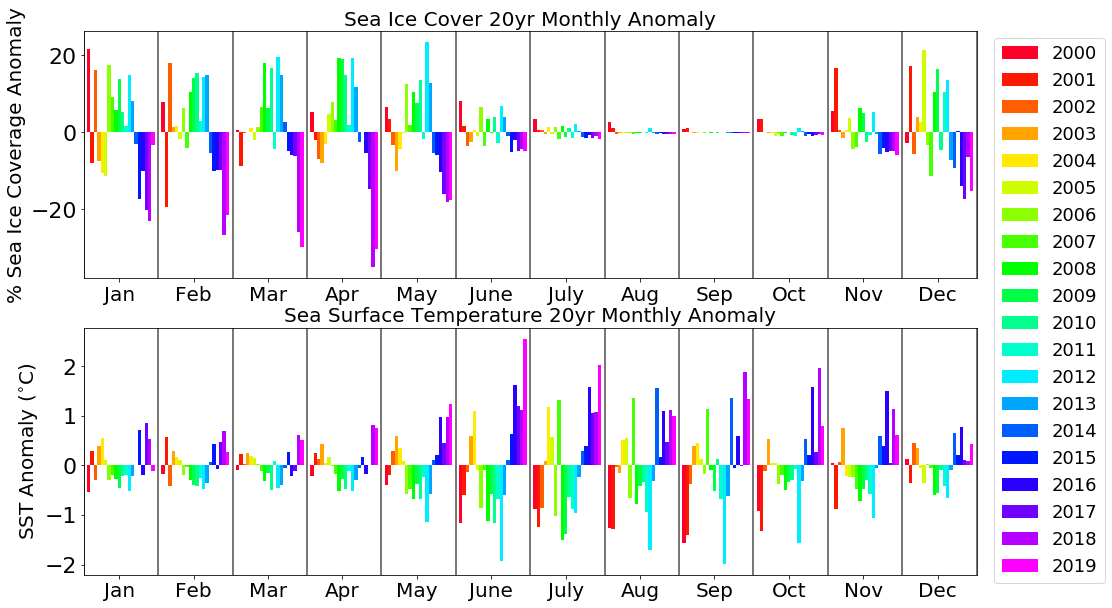

In [99]:
%autoreload
from Satellite_SeaIce_Toolbox import plot_monthly_anomalies
plot_monthly_anomalies(si = si_mask, sst = sst)

plt.savefig('Figures/20Yr_Anomalies_v3.png',dpi=300,bbox_inches='tight')

*Figure 2: Recent years have seen growing negative anomalies in sea ice cover in the Chukchi and Bering seas, particularly in the marginal months of December, April, and May (top), accompanied by positive summer SST anomalies (bottom). Data from Hamburg ICDC SSMI product (Sea Ice) and Nasa OISST Reynolds interpolated product (SST), spanning the geographical region depicted in Figure 1.*

## Figure 3: Layered Landfast Ice Extent Map

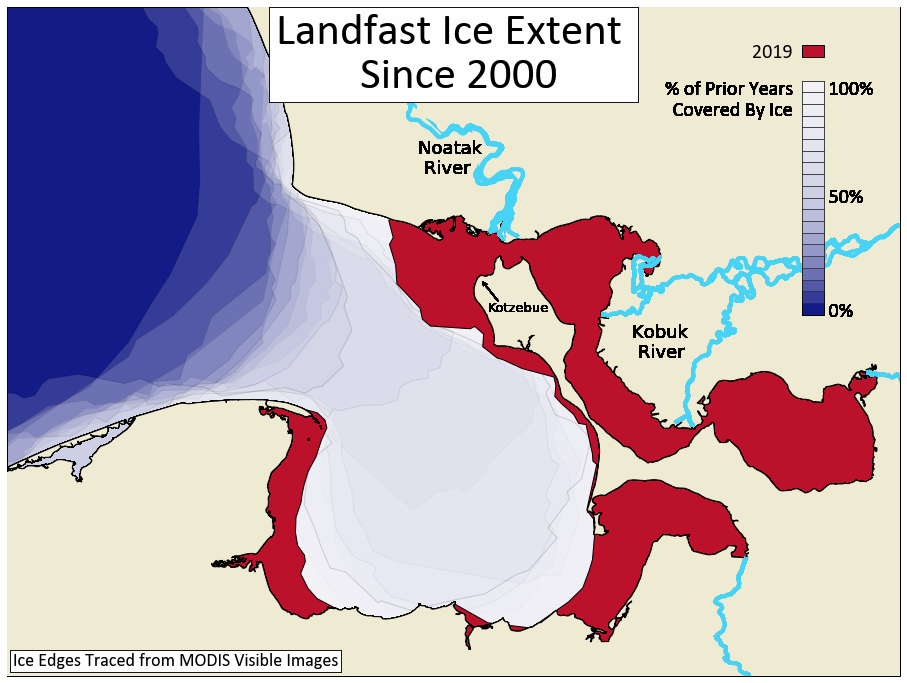

In [5]:
from Satellite_SeaIce_Toolbox import plot_layered_landfast_ice_map
plot_layered_landfast_ice_map(data_folder = '..\QGIS\Landfast Ice', 
                              coastline_path = '../QGIS/GISdata/Coastlines/Alaska_Coast_63360_py_KotzSoundRegion_WGS84.shp', 
                              river_path = '../QGIS/GISdata/Rivers/Major_Rivers_WGS84.shp', 
                              transparency = 0.15, 
                              xmin = -165.4, 
                              xmax = -160.1, 
                              ymin = 65.9, 
                              ymax = 67.55,
                              plotflag = 1)

plt.savefig(f'Figures/Layered Landfast Ice Maps/LandfastIce_to_2019_v2.png',dpi=300,facecolor='w')

*Figure 3: Landfast Ice Climatology back to 2000 plotted following the same scheme as Figure 1. The Landfast ice edge for each year was defined as a coherent ice edge that remained stationary between its formation in February/March and the breakup of the entire sound in May/June. These edges were visually identified and hand-traced from MODIS visible images in a GIS program.* 

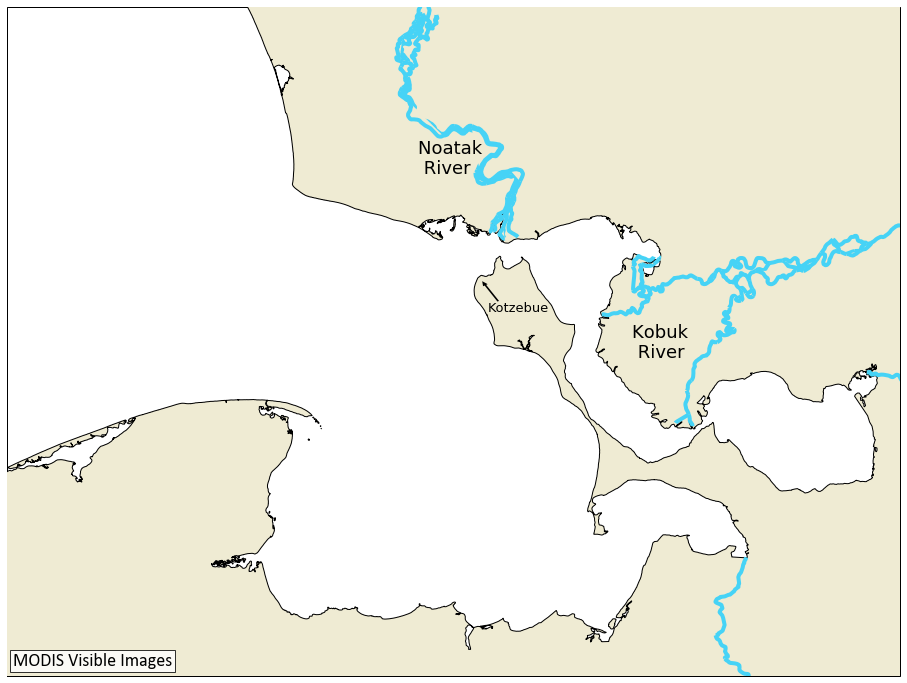

In [22]:
coastline_path = '../QGIS/GISdata/Coastlines/Alaska_Coast_63360_py_KotzSoundRegion_WGS84.shp'
river_path = '../QGIS/GISdata/Rivers/Major_Rivers_WGS84.shp'
xmin = -165.4
xmax = -160.1 
ymin = 65.9
ymax = 67.55

#define colors (could be made an input)
seacolor='#121b86'
colorstring='#ffffff'
color2019='#bc112b'

#read in shapefiles
coastline = ShapelyFeature(Reader(coastline_path).geometries(),ccrs.PlateCarree())
river = ShapelyFeature(Reader(river_path).geometries(),ccrs.PlateCarree())

#initialize map figure
fig,axx = plt.subplots(figsize=(16,16),subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=(xmin+xmax)/2,central_latitude=(ymin+ymax)/2,standard_parallels=[40,65])))
#put in background color of #121b86
axx.background_patch.set_alpha(0)
#set map extent
axx.set_extent([xmin,xmax,ymin,ymax])

#add coastline shapefile
axx.add_feature(coastline,zorder=300, edgecolor='k', facecolor='#efebd3', alpha=1)
#add rivers shapefile
axx.add_feature(river,zorder=350, edgecolor='#46d3f6', facecolor='#efebd3', alpha=1,linewidth=4)
#Add title to map
#axx.text(0.5, 0.99, 'Typical Breakup Event \n May 24 - June 21, 2012', fontsize=45, fontname='Calibri', horizontalalignment='center', verticalalignment='top', transform=axx.transAxes,
#         bbox=dict(boxstyle='square,pad=0.15', facecolor='w', alpha=0.8),zorder=400)
#Add data source to map
axx.text(0.006, 0.01, 'MODIS Visible Images', fontsize=18, fontname='Calibri', horizontalalignment='left', verticalalignment='bottom', transform=axx.transAxes,
         bbox=dict(boxstyle='square,pad=0.15', facecolor='w', alpha=0.8),zorder=400)

#label features on plot
axx.text(0.7, 0.475, 'Kobuk \n River', fontsize=18, transform=axx.transAxes, zorder=400)
axx.text(0.46, 0.75, 'Noatak \n River', fontsize=18, transform=axx.transAxes, zorder=400)
axx.text(0.538, 0.545, 'Kotzebue', fontsize=13, transform=axx.transAxes, zorder=400)
axx.add_patch(patches.Arrow(x=0.55, y=0.56, dx=-0.018, dy=0.03, width=0.01, facecolor='k',transform=axx.transAxes,zorder=400));

plt.savefig('Figures/Typical Breakup Background v2.png',dpi=300)


In [6]:
coastline_path = '../QGIS/GISdata/Coastlines/Alaska_Coast_63360_py_KotzSoundRegion_WGS84.shp'
river_path = '../QGIS/GISdata/Rivers/Major_Rivers_WGS84.shp'
xmin = -165.4
xmax = -160.1 
ymin = 65.9
ymax = 67.55

#define colors (could be made an input)
seacolor='#121b86'
colorstring='#ffffff'
color2019='#bc112b'

#read in shapefiles
coastline = ShapelyFeature(Reader(coastline_path).geometries(),ccrs.PlateCarree())
river = ShapelyFeature(Reader(river_path).geometries(),ccrs.PlateCarree())

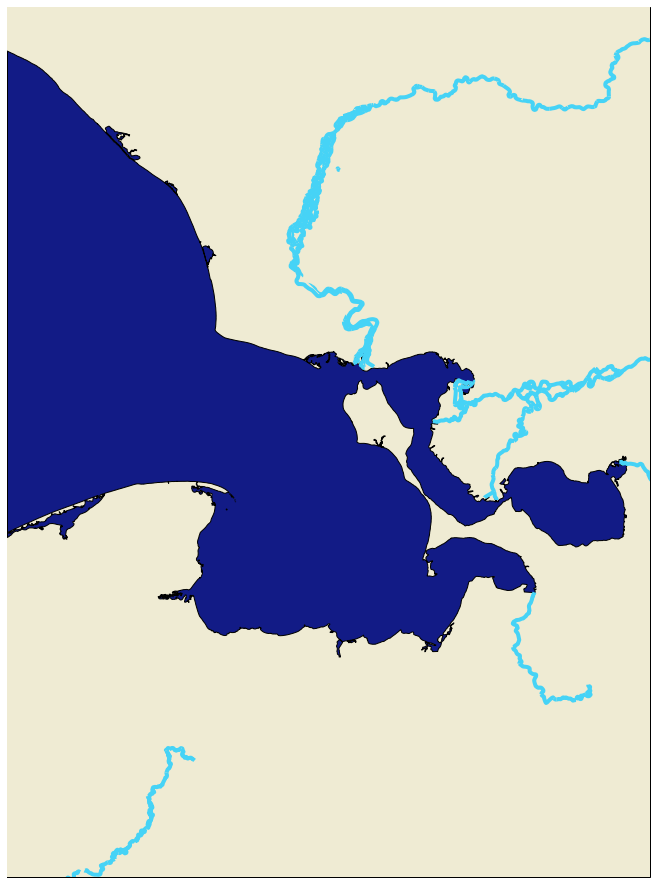

In [9]:
#initialize map figure
fig,axx = plt.subplots(figsize=(16,16),subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=(xmin+xmax)/2,central_latitude=(ymin+ymax)/2,standard_parallels=[40,65])))
#put in background color of #121b86
axx.background_patch.set_facecolor(seacolor)
#set map extent
axx.set_extent([xmin,xmax,ymin-0.7,ymax+0.7])

#add coastline shapefile
axx.add_feature(coastline,zorder=300, edgecolor='k', facecolor='#efebd3', alpha=1)
#add rivers shapefile
axx.add_feature(river,zorder=350, edgecolor='#46d3f6', facecolor='#efebd3', alpha=1,linewidth=4)
#Add title to map
#axx.text(0.5, 0.99, 'Typical Breakup Event \n May 24 - June 21, 2012', fontsize=45, fontname='Calibri', horizontalalignment='center', verticalalignment='top', transform=axx.transAxes,
#         bbox=dict(boxstyle='square,pad=0.15', facecolor='w', alpha=0.8),zorder=400)
#Add data source to map
#axx.text(0.006, 0.01, 'MODIS Visible Images', fontsize=18, fontname='Calibri', horizontalalignment='left', verticalalignment='bottom', transform=axx.transAxes,
#         bbox=dict(boxstyle='square,pad=0.15', facecolor='w', alpha=0.8),zorder=400)

#add red circle
#sis_color = 'r'
#axx.add_patch(patches.Ellipse(xy=(-162.6139,66.8968), width=0.1, height=0.04, edgecolor=sis_color, linewidth=6, transform=ccrs.PlateCarree(), facecolor='none',zorder=400));


plt.savefig('Figures/MiniMap_nolabels2.png',dpi=100)

## Figure 4: Satellite View of Kotzebue Sound Breakup
We want to communicate more explicitly what a breakup process looks like, and the idea that the historical norm is for the river to break out first. Perhaps one or two years of more "normal" conditions, and then 2019? The best years from a perspective of cloud cover are 2007 and 2012. Note that 2012 stands out in the anomaly plots as a particularly strong ice year/low SST year...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


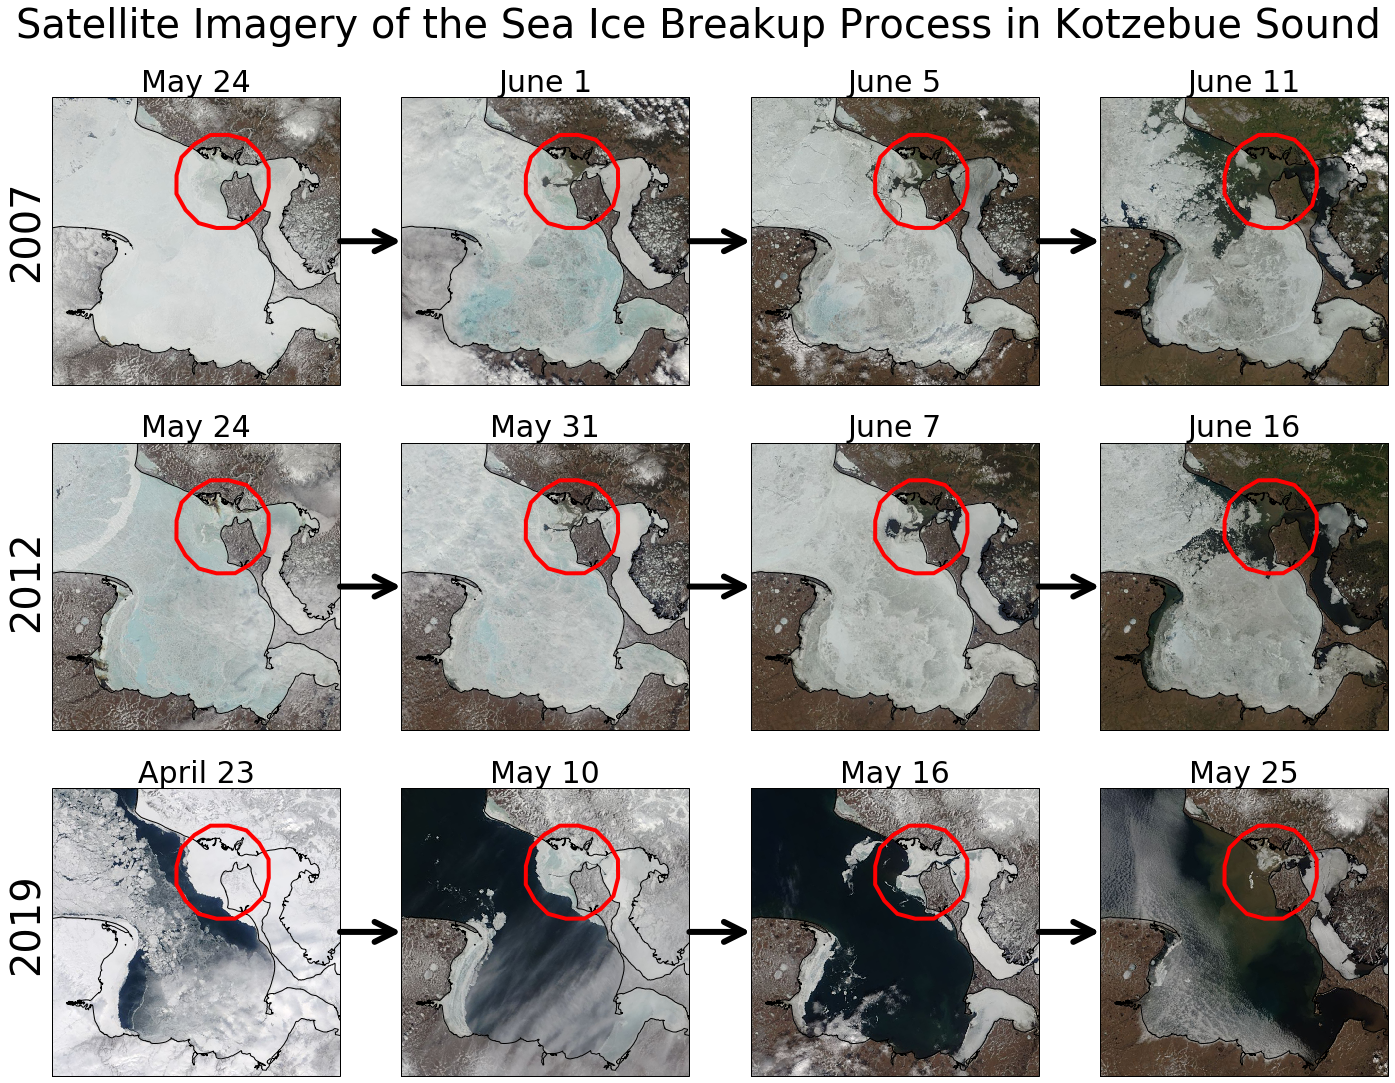

In [26]:
%load_ext autoreload
%autoreload

paths_2007 = ['../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2007/KotzSound_20070524.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2007/KotzSound_20070601.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2007/KotzSound_20070605.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2007/KotzSound_20070611.tif']
paths_2012 = ['../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2012/KotzSound_20120524.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2012/KotzSound_20120531.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2012/KotzSound_20120607.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2012/KotzSound_20120616.tif']
paths_2019 = ['../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2019/KotzSound_20190423.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2019/KotzSound_20190510.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2019/KotzSound_20190516.tif',
              '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2019/KotzSound_20190525.tif']

coastline_path = '../QGIS/GISdata/Coastlines/Alaska_Coast_63360_py_KotzSoundRegion_WGS84.shp'

%autoreload
from Satellite_SeaIce_Toolbox import plot_breakup_images
plot_breakup_images(paths_2007, paths_2012, paths_2019, coastline_path, 
                    lon_min_MOD = -164.3, 
                    lon_max_MOD = -161.3, 
                    lat_min_MOD = 66, 
                    lat_max_MOD = 67.2, 
                    fontsz = 30,
                    figsz = (24,18))

plt.savefig('./Figures/Breakup_Images_v3.png',dpi=300)

Development work:

Text(0.1, 0.21, '2019')

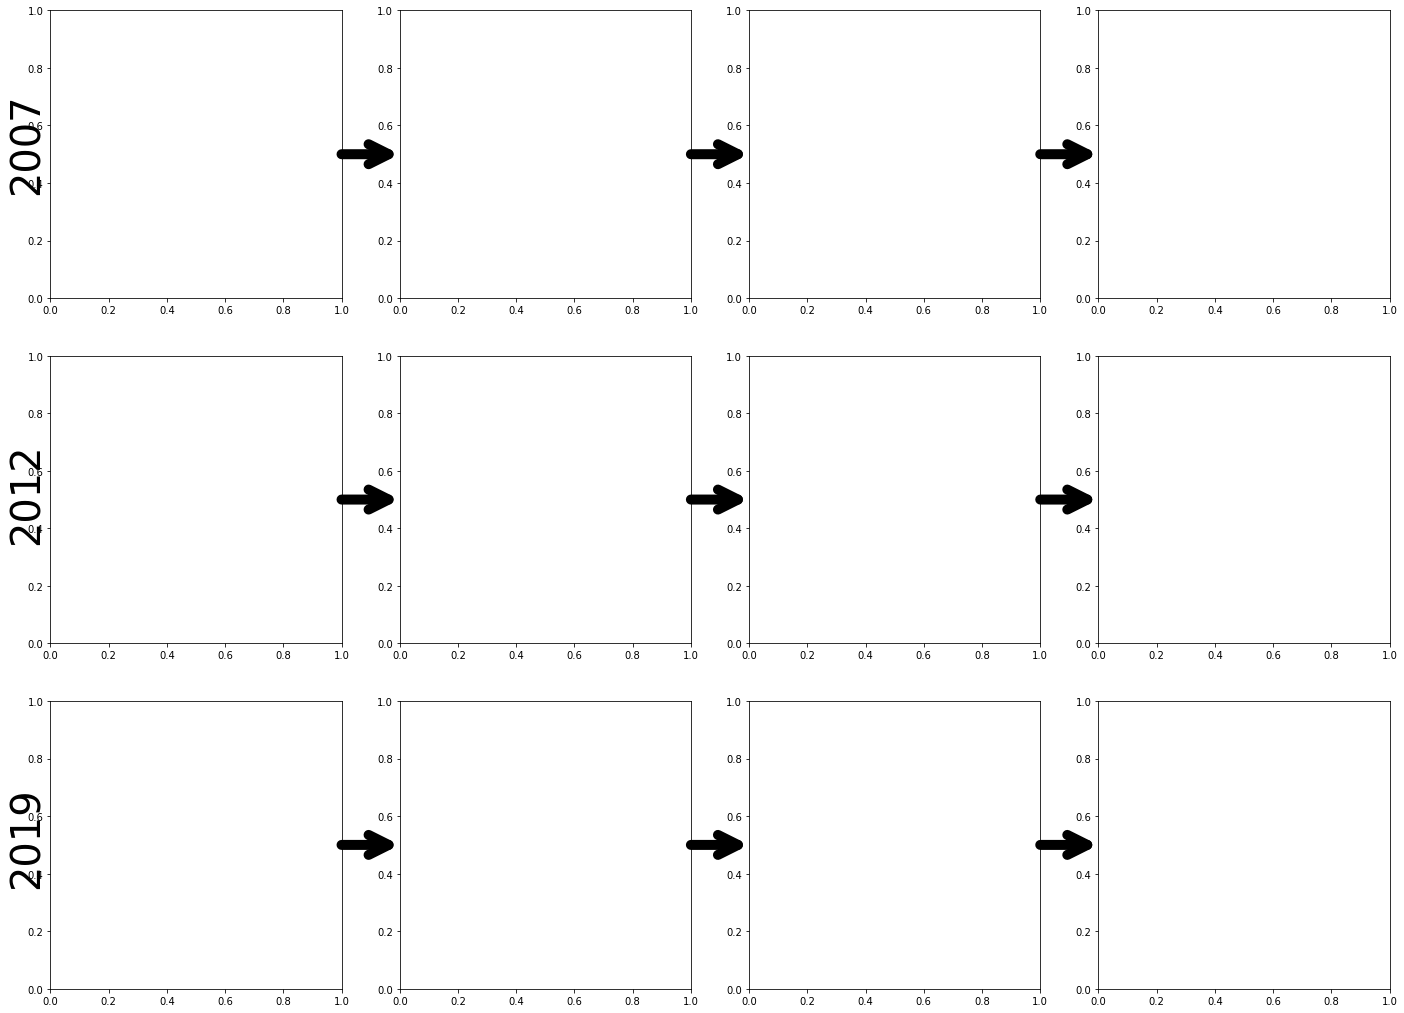

In [22]:
from matplotlib.patches import ConnectionPatch
fig, axx = plt.subplots(nrows=3,ncols=4,figsize=(24,18))

cols=4
for idx in np.arange(0,cols-1):
    for row in np.arange(0,3):
        con = ConnectionPatch(xyA=(1,0.5), coordsA=axx[row,idx].transAxes,
                              xyB=(0,0.5), coordsB=axx[row,idx+1].transAxes,
                              arrowstyle='->',linewidth=10,mutation_scale=50)
        fig.add_artist(con)

plt.figtext(x=0.1,y=0.745,s='2007',rotation=90,fontsize=40)
plt.figtext(x=0.1,y=0.475,s='2012',rotation=90,fontsize=40)
plt.figtext(x=0.1,y=0.21,s='2019',rotation=90,fontsize=40)

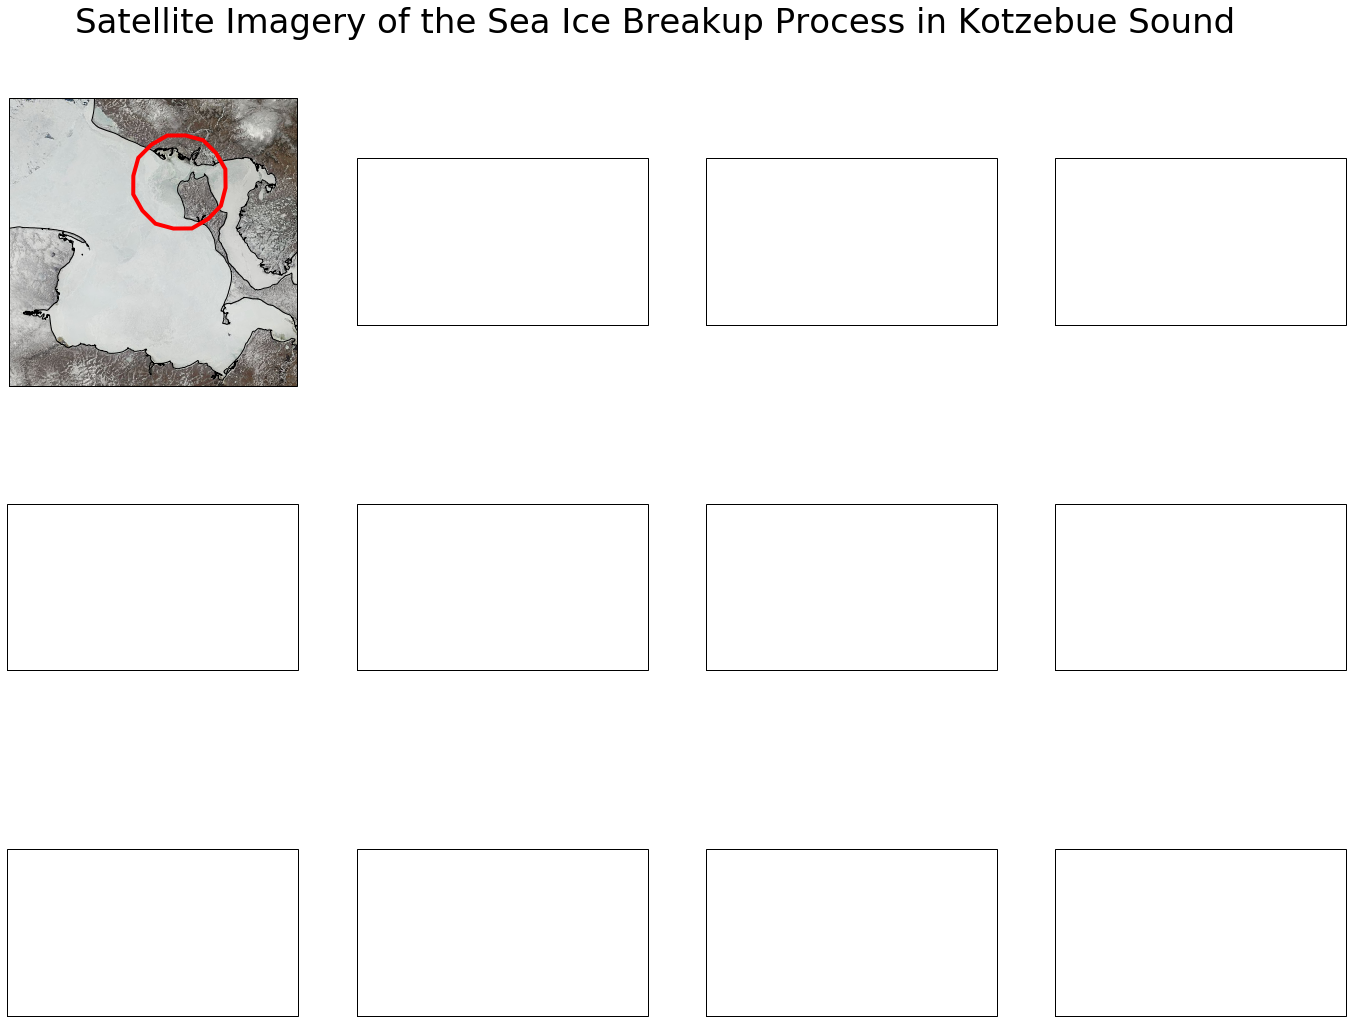

In [11]:
from Satellite_SeaIce_Toolbox import plot_MODIS_geotiff

gdal.UseExceptions()
figsz = (24,18)
lon_min_MOD = -164.3
lon_max_MOD = -161.3 
lat_min_MOD = 66
lat_max_MOD = 67.2 
fontsz = 24

cols = len(paths_2007)
coastline = ShapelyFeature(Reader(coastline_path).geometries(),ccrs.PlateCarree())

#extract coordinate system from first file to be used as projection of all subplots
fname = paths_2007[0]
ds = gdal.Open(fname)
proj = ds.GetProjection()
inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)
projcs = inproj.GetAuthorityCode('PROJCS')
projection = ccrs.epsg(projcs)
subplot_kw = dict(projection=projection)
#initialize figure
fig, axx = plt.subplots(nrows=3, ncols=cols, figsize=figsz, subplot_kw=subplot_kw, facecolor='w')
fig.suptitle('Satellite Imagery of the Sea Ice Breakup Process in Kotzebue Sound',y=0.95,fontsize=34)

for idx in np.arange(0,cols):
    plot_MODIS_geotiff(axx[0,idx], paths_2007[idx], coastline, lon_min_MOD, lon_max_MOD, lat_min_MOD, lat_max_MOD )
    axx[0,idx].add_patch(patches.Ellipse(xy=(-162.6139,66.8968), width=1.1, height=0.44, edgecolor='r', linewidth=4, transform=ccrs.PlateCarree(), facecolor='none',zorder=400));    
    break

## Figure 5: Measurement Stations in Kotzebue Sound

In [ ]:
#old version
#from Satellite_SeaIce_Toolbox import plot_measurement_stations
#plot_measurement_stations(image_path = '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2019/KotzSound_20190506.tif',
#                          image_2path = '../../Data/Satellite/Visible Imagery/KotzSound_20190507_crop2.tif',
#                          coastline_path = '../QGIS/GISdata/Coastlines/Alaska_Coast_63360_py_KotzSoundRegion_WGS84.shp',
#                          river_path = '../QGIS/GISdata/Rivers/Major_Rivers_WGS84.shp',
#                          figsz = (16,16),
#                          lon_min_MOD = -165,
#                          lon_max_MOD = -160.5, 
#                          lat_min_MOD = 66,
#                          lat_max_MOD = 67.5,
#                          sis_color = 'r',
#                          obt_color = '#00b0f0',
#                          fontsz = 28)

#plt.savefig('./Figures/MeasurementLocations_v5.png')

(made in powerpoint)

<img src='Locations and Measurements v3.png'>

Figure 5: Locations, deployment durations, and schematics of the Ocean Bottom Tripod (OBT) and Ice-Tethered Observatory (ITO) measurement stations in Kotzebue Sound. The Ocean Bottom Tripod featured measurements of water temperature, salinity, and current profiles. The Ice-Tethered Observatory featured measurements of net radiative fluxes, air temperature, humidity, pressure, wind speed, and solar insolation above the ice. Below the ice, moorings measured water temperature, salinity, and current profiles. Measurements of snow and ice thickness were made by local observers on a weekly basis using calibrated stakes. Reference Table 1 for deployment depths. The satellite image in the top right is from MODIS Visible, May 7 2019.

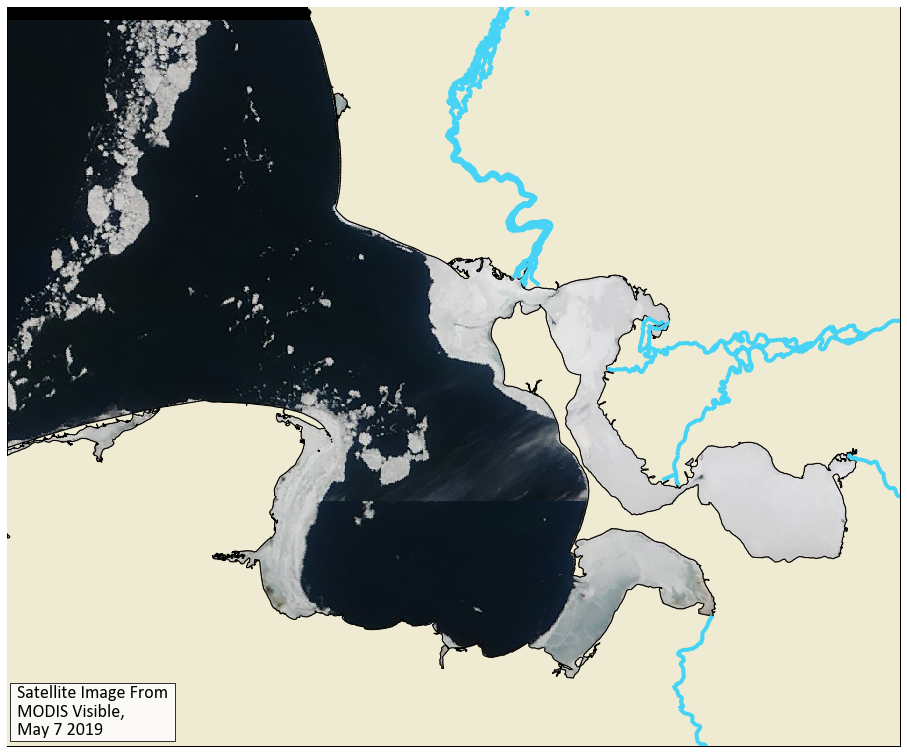

In [28]:
from Satellite_SeaIce_Toolbox import plot_may2019_image
plot_may2019_image(image_path = '../../Data/Satellite/Visible Imagery/MODIS_KotzSound/2019/KotzSound_20190506.tif',
                          image_2path = '../../Data/Satellite/Visible Imagery/KotzSound_20190507_crop2.tif',
                          coastline_path = '../QGIS/GISdata/Coastlines/Alaska_Coast_63360_py_KotzSoundRegion_WGS84.shp',
                          river_path = '../QGIS/GISdata/Rivers/Major_Rivers_WGS84.shp',
                          figsz = (16,16),
                          lon_min_MOD = -165.4,
                          lon_max_MOD = -160.1 , 
                          lat_min_MOD = 65.9,
                          lat_max_MOD = 67.55,
                          sis_color = 'r',
                          obt_color = '#00b0f0',
                          fontsz = 28)

plt.savefig('./Figures/May2019Image.png',dpi=300)

## Figure 6: SIS Schematic
(made in Powerpoint)

![](./Figures/ITO Schematic v1.png)

*Figure 6: The Ice-Tethered Observatory featured measurements of net radiative fluxes, air temperature, humidity, pressure, wind speed, and solar insolation above the ice. Below the ice, moorings measured water temperature, salinity, and current profiles (see Table 1 for deployment depths). Measurements of snow and ice thickness were made by local observers on a weekly basis using calibrated stakes.*

## Figure 6: Overview of ITO Measurements

In [2]:
#----Declare Variables----
lat, lon = 66.8968, -162.6139
start, end = pd.datetime(2019,1,7,22,45,0), pd.datetime(2019,4,1,20,0,0)

#----Load QC'd Data-------
aqd2dir = xr.open_dataset("../Sea Ice Station & OBT/Pickles/aquadopp_currents.nc")
aqd2dir = aqd2dir.where(aqd2dir.bindepth>1)
aqdXr = xr.open_dataset("../Sea Ice Station & OBT/aquadopp_currents_real.nc")
tempsXr = xr.open_dataarray("../Sea Ice Station & OBT/Pickles/temperature_uninterpolated.nc")
tempsXrInterp = xr.open_dataarray("../Sea Ice Station & OBT/Pickles/temperature_profile.nc")
rbr = pickle.load( open( "../Sea Ice Station & OBT/Pickles/concerto_10minResample.p", "rb" ))
rbr = rbr[1:] #to line times up with tempsXr
maximet = pickle.load( open( "../Sea Ice Station & OBT/Pickles/maximet_selectedvars_10minResample_QCv1.p", "rb" ) )
cnr_rsmpl = pickle.load( open( "../Sea Ice Station & OBT/Pickles/cnr_10minResample.p", "rb" ))
mbs_mean = pickle.load( open( "../Sea Ice Station & OBT/Pickles/mbs_channel_meanValues.p", "rb" ))
fws_rsmpl = pickle.load( open( "../Sea Ice Station & OBT/Pickles/fws_10minResample.p", "rb" ))
tt = pd.read_pickle('../Sea Ice Station & OBT/Pickles/tinytag.p')

C:\Users\cwitt\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


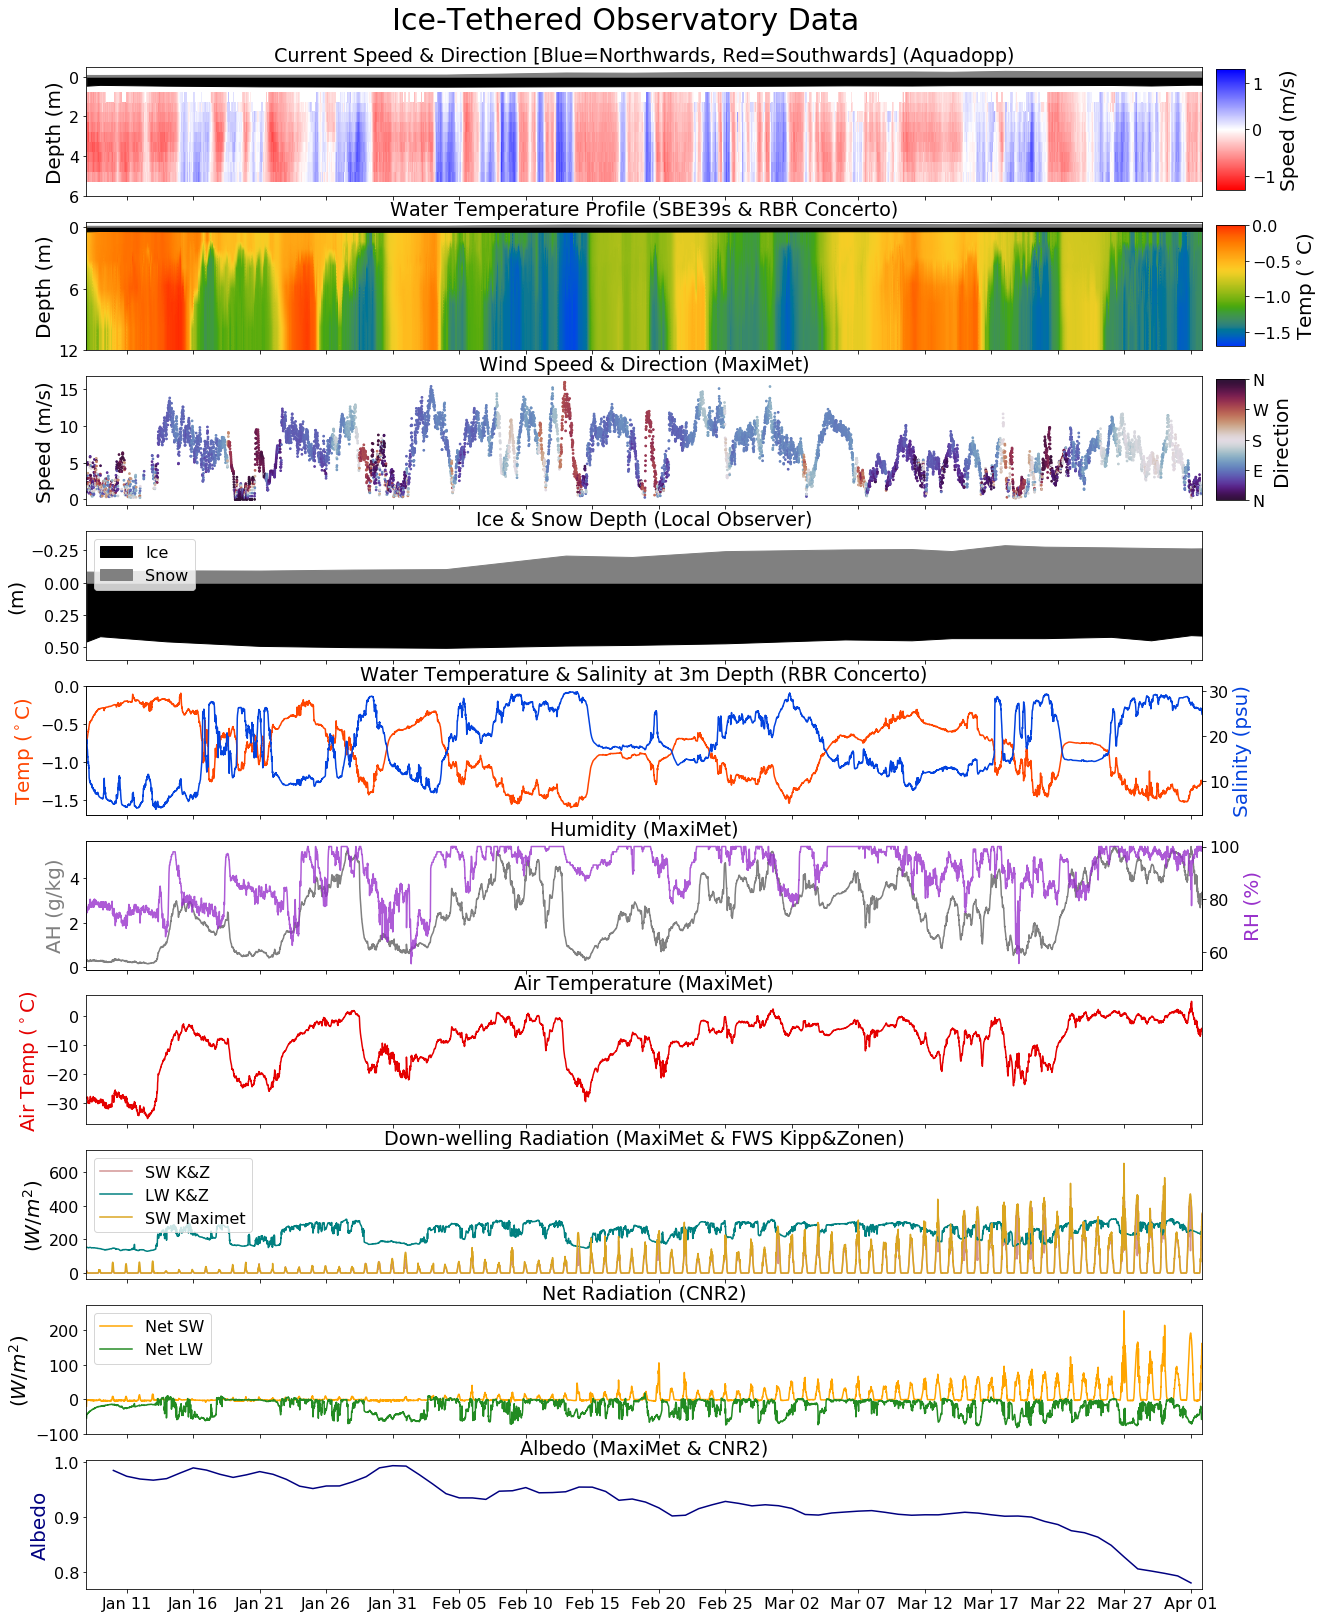

In [11]:
from IkSi_Analysis_Toolbox import plot_overview_timeseries
plot_overview_timeseries(start, end, aqd2dir, mbs_mean, tempsXrInterp, rbr, maximet, fws_rsmpl, cnr_rsmpl)

plt.savefig('Figures/OverviewTimeseries_v3.png',dpi=300)

*Figure 7: Summary of all measurements made on the ITO: bi-directional water currents; water temperatures & salinity; wind speed & direction; ice & snow thickness; air temperature, humidity, and pressure; net LW and SW radiation; and down-welling SW radiation. Also shown are down-welling LW and SW radiation measurements from a tower above the Fish & Wildlife Service (FWS) building in the town of Kotzebue. Daily albedo values are shown in the bottom panel, calculated by differencing the CNR2 net radiometer from the down-welling SW sensor on the MaxiMet.*

## Figure 8: Bi-directional current correlations

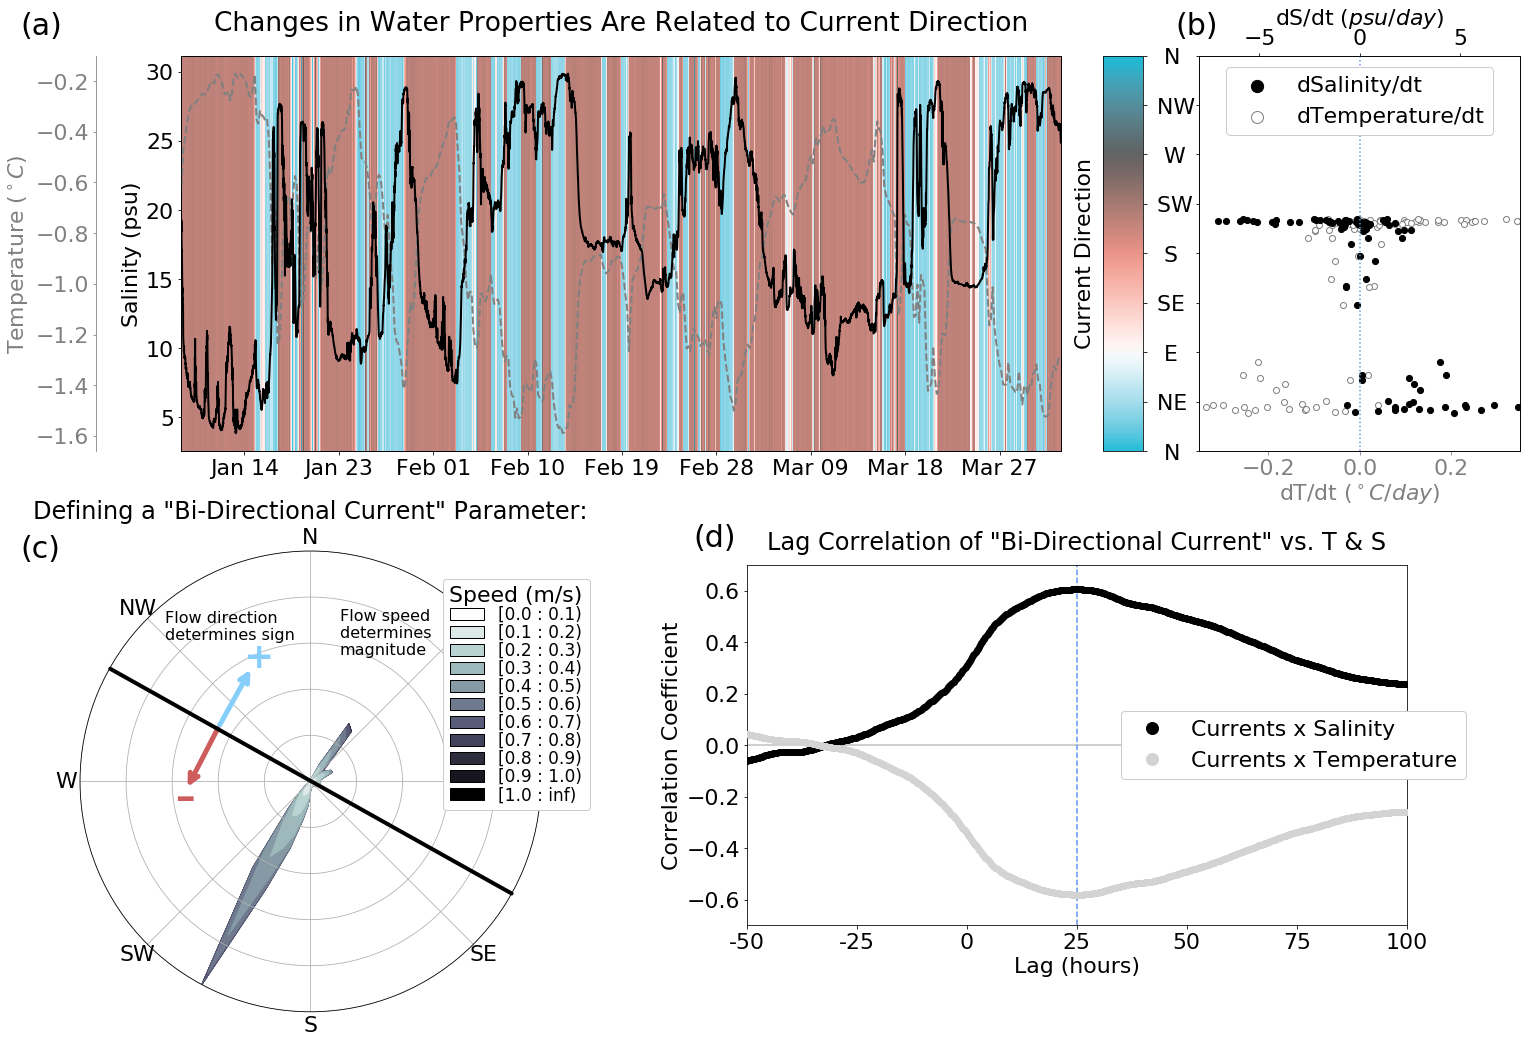

In [25]:
#OLD FIGURE
#from IkSi_Analysis_Toolbox import bidir_current_correlations
#bidir_current_correlations(aqdXr, aqd2dir, tempsXrInterp, rbr)
#plt.savefig('Figures/bidirCurrents.png',dpi=300)
%autoreload
from IkSi_Analysis_Toolbox import currents_vs_TS
currents_vs_TS(rbr,aqdXr,aqd2dir,start,end)

plt.savefig('Figures/TS_Currents_v2.png',dpi=300)

*Figure 8: [Top Left] Salinity (black) and Temperature (gray) timeseries plotted atop a color code corresponding to the direction of flow in the channel. [Top Right] shows the clear relationship between flow direction and rates of change of Salinity and Temperature. Northward flow brings colder, saltier water, while Southward flow brings warmer, fresher water. [Bottom Left] Directional histogram of currents measured at the Sea Ice Station. Because of the bi-modal behavior, we define a "Bi-Directional Current" parameter whose magnitude is the measured speed, but whose sign is assigned based on the flow direction. [Bottom Right] Lag correlations between the "Bi-Directional Current" parameter and both water temperature (black) & salinity (gray).*

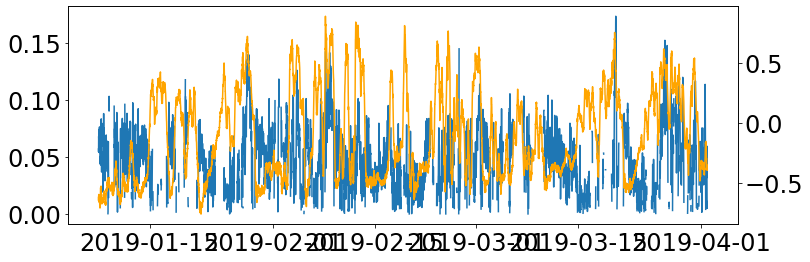

In [20]:
fig,ax1= plt.subplots(figsize=(12,4),facecolor='w')
meandir = aqd2dir.direction.mean(dim='bindepth').values
#ax1.pcolormesh(aqd2dir.time,[0,1],[meandir,meandir],cmap=cc.cm.cyclic_tritanopic_cwrk_40_100_c20,vmin=0,vmax=360)
ax1.plot(deltaT.index,ustar)
par = ax1.twinx()
currs = aqd2dir.mean(dim='bindepth').speed
par.plot(currs.time,currs,'orange')


In [23]:
len(ustar),len(currs)

(8054, 8054)

(array([-1,  0,  1]),
 array([-0.28227966, -0.28150864, -0.28054539]),
 <matplotlib.lines.Line2D at 0x22cf5182c88>)

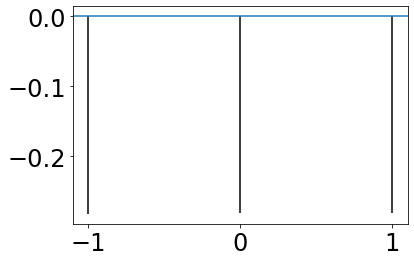

In [30]:
plt.xcorr(ustar[~np.isnan(ustar)],currs[~np.isnan(ustar)],maxlags=1)

(array([-1,  0,  1]),
 array([-0.96811855, -0.96881147, -0.96890221]),
 <matplotlib.lines.Line2D at 0x1cb404ce088>)

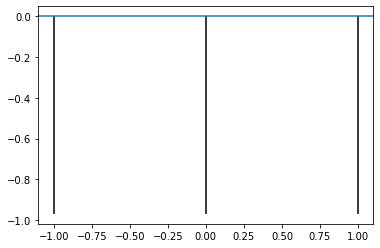

In [5]:
plt.xcorr(rbr.Salinity-rbr.Salinity.mean(),rbr.Temperature-rbr.Temperature.mean(),maxlags=1)

## $u_{*0}$ and St vs Re

C:\Users\cwitt\Anaconda3\lib\site-packages\xarray\core\nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


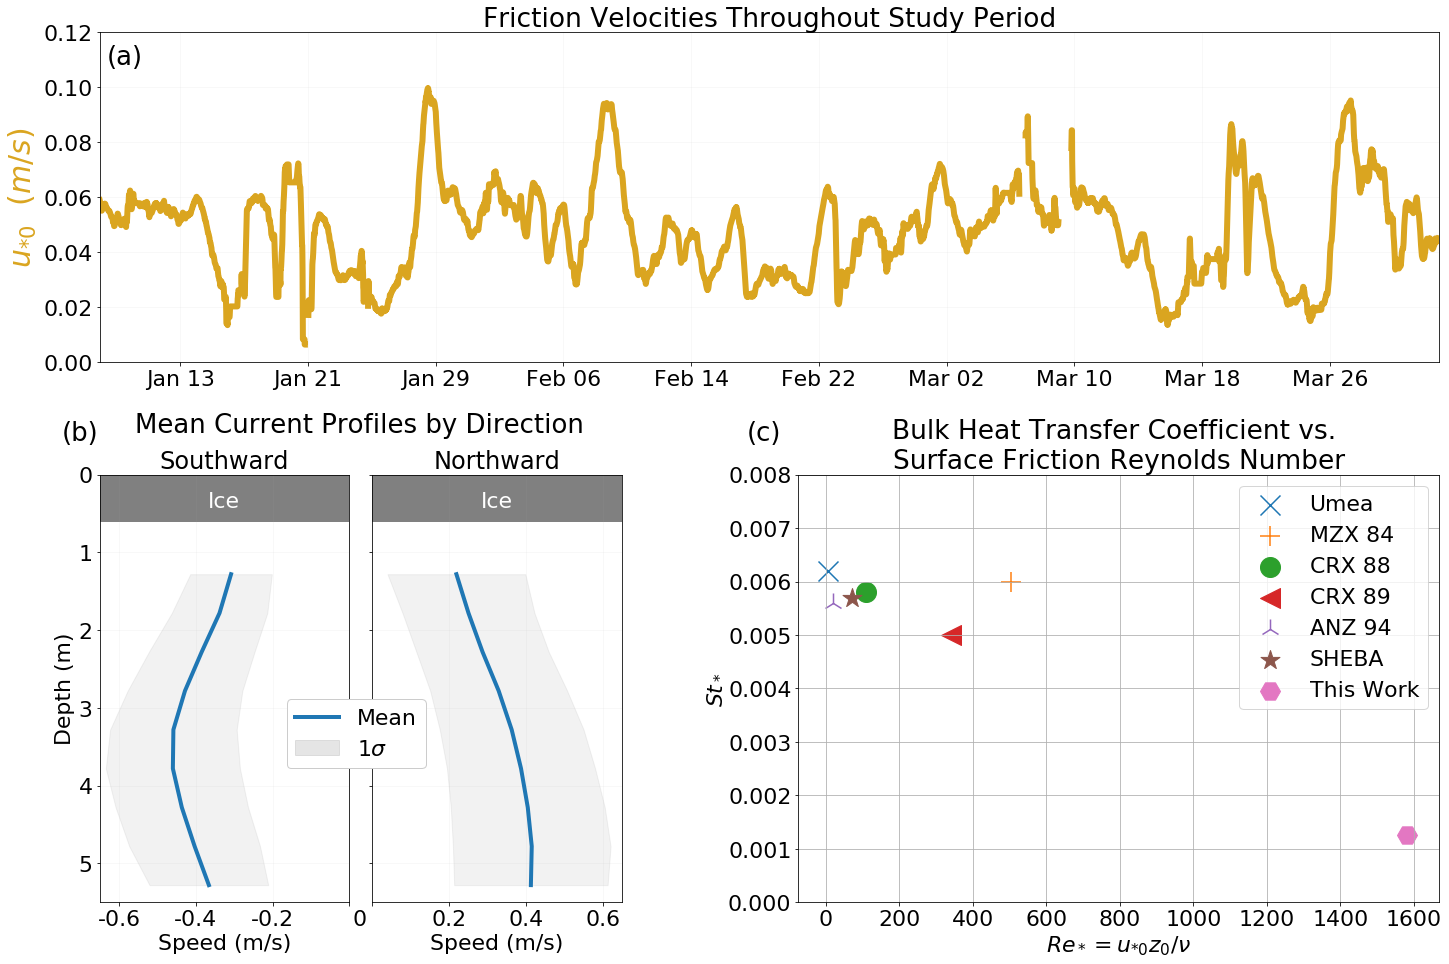

In [42]:
from IkSi_Analysis_Toolbox import calculate_deltaT, calculate_ustar, plot_thermodynamic_forcing
roll=4 #number of 15-minute periods to calculate the rolling mean over
plt.rcParams['font.size'] = 24
rbr = calculate_deltaT(rbr, tempsXrInterp)
rbr_rsmpl = rbr.resample('15min').mean()
deltaT = rbr_rsmpl.deltaT_Adjusted.rolling(roll,center=True).mean()
ustar = calculate_ustar(aqdXr, roll)

linewd = 3

fig = plt.figure(figsize=(24,16),facecolor='w')
plt.rcParams['font.size'] = 22

#-------Plot Ustar timeseries----------------
ustar_daily = ustar.rolling(time=4*24,center=True,min_periods=2).mean()
ustar_err = ustar.rolling(time=4*24,center=True,min_periods=2).std()

ax1 = plt.subplot2grid(shape=(5,1),loc=(0,0),rowspan=2,colspan=1,fig=fig)
#ax1.fill_between(ustar_daily.time.values,y1=ustar_daily-ustar_err,y2=ustar_daily+ustar_err,color='lightgrey',alpha=0.6)
ax1.plot(ustar_daily.time.values,ustar_daily,'goldenrod',linewidth=linewd*2,alpha=1)
ax1.set_ylabel('$u_{*0}$  $(m/s)$',color='goldenrod',fontsize=30)
ax1.set_ylim([0,0.12])
ax1.set_title('Friction Velocities Throughout Study Period')
#ax1.legend(['1$\sigma$','$u_{*0}$'])
ax1.grid(alpha=0.1)

ax1.set_xlim([start, end])
ax1.xaxis.set_major_locator(ticker.MultipleLocator(8))
myFmt = mdates.DateFormatter('%b %d')
ax1.xaxis.set_major_formatter(myFmt);

#---------Plot mean current profiles--------------
minv = 0.1

aqdNdir = aqd2dir.where(aqd2dir.speed.mean(dim='bindepth')>minv)
aqdNdir_mean = aqdNdir.speed.mean(dim='time',skipna=True)
aqdNdir_std = aqdNdir.speed.std(dim='time',skipna=True)

aqdSdir = aqd2dir.where(aqd2dir.mean(dim='bindepth').speed<-minv)
aqdSdir_mean = aqdSdir.speed.mean(dim='time',skipna=True)
aqdSdir_std = aqdSdir.speed.std(dim='time',skipna=True)

ax21 = plt.subplot2grid(shape=(10,10),loc=(5,0),rowspan=5,colspan=2,zorder=10)
ax21.plot(aqdSdir_mean,aqdSdir.bindepth,linewidth=4)
ax21.fill_betweenx(aqdSdir.bindepth,(aqdSdir_mean-aqdSdir_std),(aqdSdir_mean+aqdSdir_std),color='grey',alpha=0.1)
ax21.axhspan(0,0.6,color='grey')
ax21.set_ylim([0,5.5])
ax21.set_xlim([-0.65,0])
ax21.set_xticks([0,-0.2,-0.4,-0.6])
ax21.set_xticklabels(['   0','-0.2','-0.4','-0.6'])
ax21.invert_yaxis()
ax21.set_ylabel('Depth (m)')
ax21.set_xlabel('Speed (m/s)')
ax21.set_title('Southward',fontsize=24)
ax21.grid(alpha=0.1)
ax21.text(0.435,0.925,'Ice',color='w', transform=ax21.transAxes)
legHs = ax21.legend(['Mean','1$\sigma$'],bbox_to_anchor=(1.35,0.5),framealpha=1)
legHs.legendHandles[1].set_alpha(0.2)


ax22 = plt.subplot2grid(shape=(10,10),loc=(5,2),rowspan=5,colspan=2)

ax22.plot(aqdNdir_mean,aqdNdir.bindepth,linewidth=4)
ax22.fill_betweenx(aqdNdir.bindepth,(aqdNdir_mean-aqdNdir_std),(aqdNdir_mean+aqdNdir_std),color='grey',alpha=0.1)
ax22.axhspan(0,0.6,color='grey')
ax22.set_xlim([0,0.65])
ax22.set_ylim([0,5.5])
ax22.set_yticklabels([])
ax22.set_xticks([0,0.2,0.4,0.6])
ax22.set_xticklabels(['','0.2','0.4','0.6'])
ax22.invert_yaxis()
ax22.set_title('Northward',fontsize=24)
ax22.set_xlabel('Speed (m/s)')
ax22.grid(alpha=0.1)
ax22.text(0.435,0.925,'Ice',color='w', transform=ax22.transAxes)

ax21.text(0.14,1.1,'Mean Current Profiles by Direction', transform=ax21.transAxes,fontsize=26)

#----------Plot St vs. Re -----------------

StvRe = pd.read_csv('../../Data/Sea Ice Station/HeatFluxScaling/ReynoldsNumber_vs_StantonNumber.csv',index_col=0)

ax23 = plt.subplot2grid(shape=(10,4),loc=(5,2),rowspan=5,colspan=2)

mkr_dict = {'Umea': 'x', 'MZX 84': '+', 'CRX 88': 'o','CRX 89':'<','ANZ 94':'2','SHEBA':'*','This Work':'H'}
for experiment in mkr_dict:
    d = StvRe[StvRe.index==experiment]
    ax23.scatter(d.Re, d.St,s = 400, marker = mkr_dict[experiment])

ax23.set_ylim([0,0.008])
ax23.grid()
ax23.set_xlabel(r'$Re_* = u_{*0}z_0/\nu$')
ax23.set_ylabel('$St_*$')
ax23.set_title('Bulk Heat Transfer Coefficient vs. \nSurface Friction Reynolds Number')#,fontdict={'fontsize':'16'})
ax23.legend(StvRe.index)

plt.text(x=-1.08,y=1.96,s='(a)',transform=plt.gca().transAxes,fontsize=26)
plt.text(x=-1.15,y=1.08,s='(b)',transform=plt.gca().transAxes,fontsize=26)
plt.text(x=-0.08,y=1.08,s='(c)',transform=plt.gca().transAxes,fontsize=26)
   
plt.savefig('./Figures/ustar_v3.png',dpi=600)

In [4]:
minv = 0.1

aqdNdir = aqd2dir.where(aqd2dir.speed.mean(dim='bindepth')>minv)
aqdNdir_mean = aqdNdir.speed.mean(dim='time',skipna=True)
aqdNdir_std = aqdNdir.speed.std(dim='time',skipna=True)

aqdSdir = aqd2dir.where(aqd2dir.mean(dim='bindepth').speed<-minv)
aqdSdir_mean = aqdSdir.speed.mean(dim='time',skipna=True)
aqdSdir_std = aqdSdir.speed.std(dim='time',skipna=True)

C:\Users\cwitt\Anaconda3\lib\site-packages\xarray\core\nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
aqdNdir_mean

<xarray.DataArray 'speed' (bindepth: 15)>
array([0.41349533, 0.41571128, 0.40536654, 0.38782763, 0.3634716 ,
       0.32958139, 0.28765736, 0.25105033, 0.21962332,        nan,
              nan,        nan,        nan,        nan,        nan])
Coordinates:
  * bindepth  (bindepth) float64 5.28 4.78 4.28 3.78 ... -0.7197 -1.22 -1.72

In [10]:
aqdSdir_mean.dropna(dim='bindepth')

<xarray.DataArray 'speed' (bindepth: 9)>
array([-0.36571981, -0.40285435, -0.436165  , -0.45946965, -0.45809629,
       -0.42790394, -0.38439626, -0.33798797, -0.30801289])
Coordinates:
  * bindepth  (bindepth) float64 5.28 4.78 4.28 3.78 3.28 2.78 2.28 1.78 1.28

In [16]:
duSdz = -0.33798797 - -0.30801289
duNdz = 0.21962332 - 0.25105033

np.round(duSdz*2,decimals=3), np.round(duNdz*2,decimals=3)

(-0.06, -0.063)

In [24]:
duSdz = -0.38439626 - -0.30801289
duNdz = 0.21962332 - 0.28765736

np.round(duSdz,decimals=3), np.round(duNdz,decimals=3)

(-0.076, -0.068)

In [89]:
from IkSi_Analysis_Toolbox import calculate_deltaT, calculate_ustar, plot_thermodynamic_forcing
roll=4 #number of 15-minute periods to calculate the rolling mean over
plt.rcParams['font.size'] = 24
rbr = calculate_deltaT(rbr, tempsXrInterp)
rbr_rsmpl = rbr.resample('15min').mean()
deltaT = rbr_rsmpl.deltaT_Adjusted.rolling(roll,center=True).mean()
ustar = calculate_ustar(aqdXr, roll)
#plot_thermodynamic_forcing(deltaT, ustar, start, end)

#plt.savefig('Figures/Thermodynamic Forcing_v2.png')

*Figure 8: Timeseries of friction velocity $u_{*0}$ and departure from freezing $ΔT$, the two terms affecting variations in the magnitude of the ocean-ice heat flux.* 

## Figure 9: $St*$ vs $Re*$ for existing data sets compared to our data set

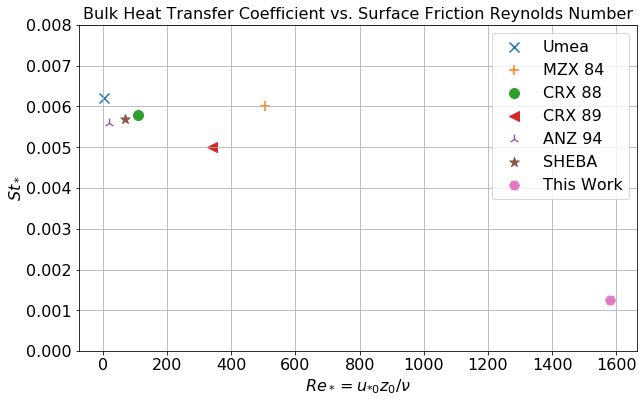

In [14]:
from IkSi_Analysis_Toolbox import plot_St_vs_Re
StvRe = pd.read_csv('../../Data/Sea Ice Station/HeatFluxScaling/ReynoldsNumber_vs_StantonNumber.csv',index_col=0)
plot_St_vs_Re(StvRe)

plt.savefig('./Figures/St_v_Re_v1.png',dpi=300)

*Figure 9: Stanton number has displayed no dependence on roughness Reynolds number for existing in-situ data sets of under-ice heat flux measurements, however this study suggests that the dependence anticipated from laboratory studies may emerge at sufficiently large roughness Reynolds numbers.*

## Figure 10: Flux balances at both interfaces

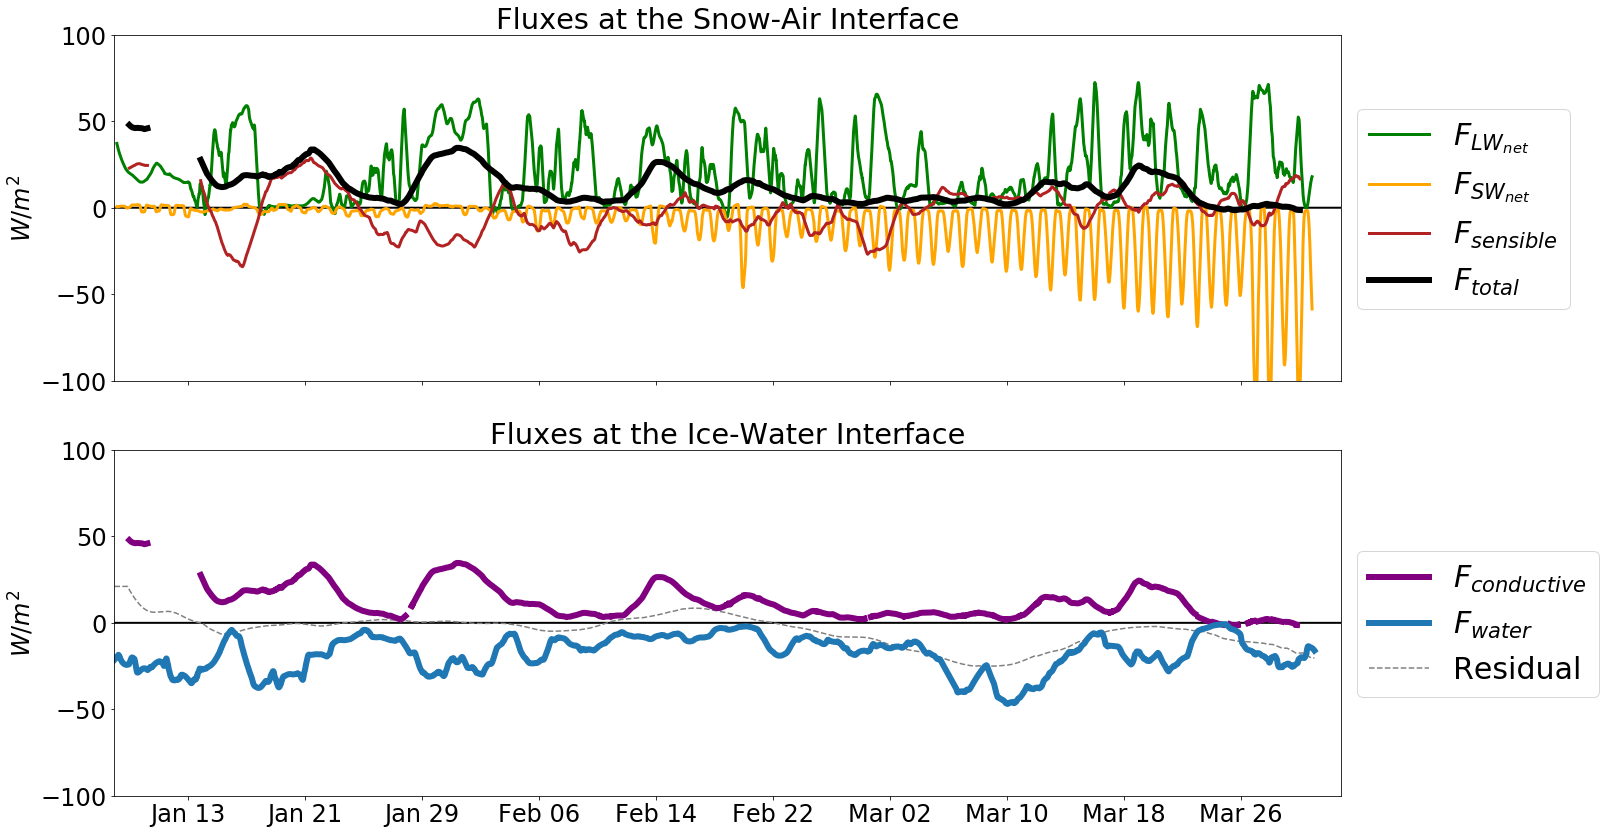

In [9]:
from IkSi_Analysis_Toolbox import calculate_Fw, plot_flux_balances
#calculate ocean-ice heat flux following McPhee '92
Fw_92 = calculate_Fw(deltaT, ustar, rbr_rsmpl, lon, lat)
#Update mass balance data to reflect ice and snow thickness treating flooded snow as ice
mbs_mean = pd.read_csv('../../Data/Sea Ice Station/MassBalance/mbs_mean_withflooding.csv',index_col=0,parse_dates=True,usecols=[0,1,2])
#calculate and plot flux balances at both boundaries
plot_flux_balances(mbs_mean, maximet, cnr_rsmpl, rbr_rsmpl, Fw_92)

plt.savefig('./Figures/Flux Balances v3.png',dpi=300)

*Figure 10: Flux balances at the top and bottom interfaces of the snow/ice layer. Positive values correspond to fluxes away from an interface, while negative values correspond to fluxes into an interface. The conductive flux away from the bottom interface balances the total flux away from the top interface, and differences between the water-ice heat flux and the conductive flux should lead to ice growth or melt at the bottom interface. A 10-day rolling mean of the residual between the water-ice heat flux and the conductive flux suggests the onset of under-ice melting in mid-February.*

## Figure 11: Relationship Between Salinity & Departure From Freezing Point

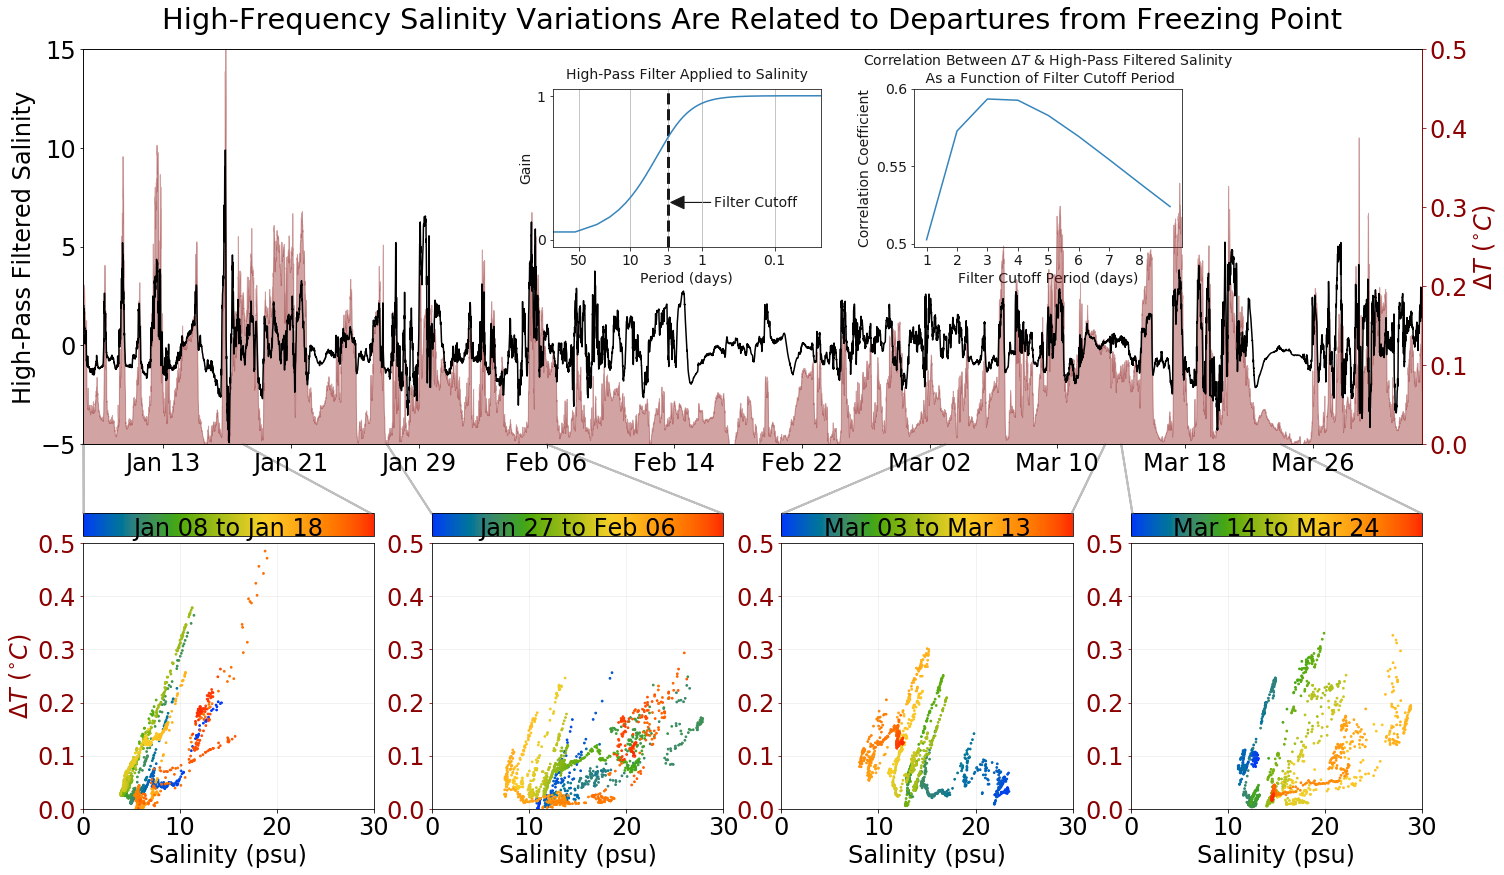

In [46]:
#OLD VERSION OF THIS FIGURE:
#start_sub1,end_sub1 = pd.datetime(2019,1,8),pd.datetime(2019,1,18)
#start_sub2,end_sub2 = pd.datetime(2019,3,3),pd.datetime(2019,3,13)
#from IkSi_Analysis_Toolbox import plot_sal_v_deltaT
#plot_sal_v_deltaT(rbr, start_sub1, end_sub1, start_sub2, end_sub2)

%autoreload
#NEW VERSION:
from IkSi_Analysis_Toolbox import plot_filtered_sal_v_deltaT
plt.rcParams.update({'font.size': 24})
plot_filtered_sal_v_deltaT(rbr, start, end)

plt.savefig('./Figures/Sal_v_dT_v3.png',dpi=300)

*Figure 11: Sudden increases in salinity correspond to departures of water temperature from the freezing point, implying an oceanic origin for residual heat in the water under the ice. The slope of the excursions in ΔT-Salinity space is very consistent, suggesting a characteristic relationship between salinity excursions & heat content.*

## Figure 12: Temperature and Salinity at OBT - Spring and Fall

In [47]:
#import data
sbeOBT = pd.read_pickle('../../Data/Ocean Bottom Tripod/Pickles/sbe_OBT_2019.p')
sbeOBT18 = pd.read_pickle('../../Data/Ocean Bottom Tripod/Pickles/sbe_OBT_2018.p')

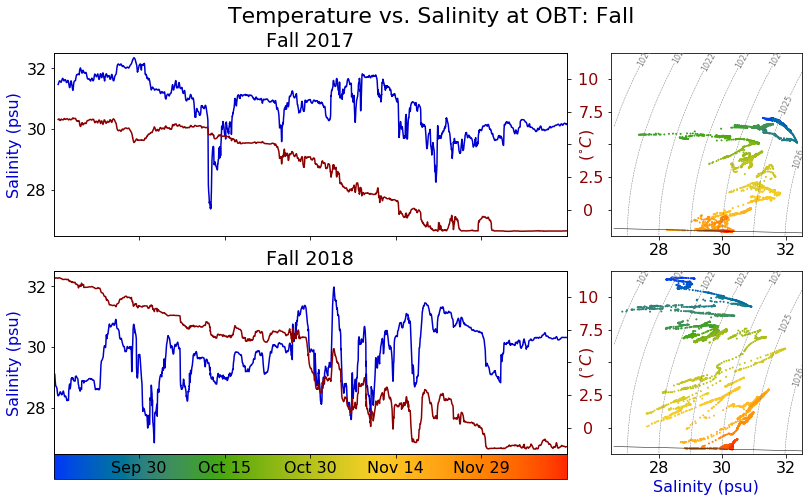

In [21]:
from IkSi_Analysis_Toolbox import plot_OBT_sections
plot_OBT_sections(sbeOBT18, sbeOBT, 
                  start1 = pd.datetime(2017,9,15,0,0,0), end1 = pd.datetime(2017,12,15,0,0,0),
                  start2 = pd.datetime(2018,9,15,0,0,0), end2 = pd.datetime(2018,12,15,0,0,0),
                  sal_lims = [26.5,32.5], 
                  temp_lims = [-2, 12], temp_ticks = [0,2.5,5,7.5,10], temp_tick_labels = ['0  ','2.5','','7.5','10 '],
                  nticks = 5, 
                  title1 = 'Fall 2017',
                  title2 = 'Fall 2018',
                  supTitle = 'Temperature vs. Salinity at OBT: Fall')

plt.savefig('./Figures/OBT_TS_Fall_v1.png',dpi=300)

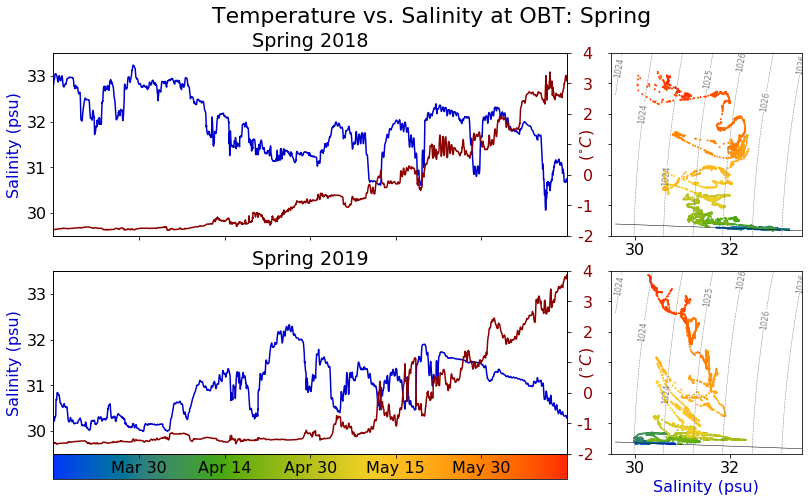

In [22]:
from IkSi_Analysis_Toolbox import plot_OBT_sections
plot_OBT_sections(sbeOBT18, sbeOBT, 
                  start1 = pd.datetime(2018,3,15,0,0,0), end1 = pd.datetime(2018,6,15,0,0,0),
                  start2 = pd.datetime(2019,3,15,0,0,0), end2 = pd.datetime(2019,6,15,0,0,0),
                  sal_lims = [29.5,33.5], 
                  temp_lims = [-2, 4], temp_ticks = [-2,-1,0,1,2,3,4], temp_tick_labels = ['-2  ','-1  ','0  ','','2  ','3  ','4  '],
                  nticks = 5, 
                  title1 = 'Spring 2018',
                  title2 = 'Spring 2019',
                  supTitle = 'Temperature vs. Salinity at OBT: Spring')

plt.savefig('./Figures/OBT_TS_Spring_v1.png',dpi=300)

*Figure 12: At the mouth of Kotzebue Sound, temperature and salinity are positively correlated in the Fall (a), but negatively correlated in the Spring (b) for both years of measurements.*

## Figure 13: T-S Diagram of fall vs. spring at OBT

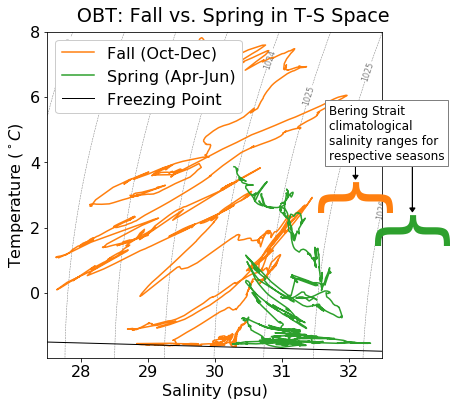

In [87]:
%autoreload

from IkSi_Analysis_Toolbox import plot_OBT_fallVspring_TS
plot_OBT_fallVspring_TS(sbeOBT, 
                        fall_start_18 = pd.datetime(2018,10,15,0,0,0), 
                        fall_end_18 = pd.datetime(2018,12,15,0,0,0), 
                        spring_start_19 = pd.datetime(2019,4,15,0,0,0), 
                        spring_end_19 = pd.datetime(2019,6,15,0,0,0))


plt.savefig('./Figures/OBT_TS_FallSpring_v2.png',dpi=300,bbox_inches='tight')

*Figure 13: Temperature-Salinity diagram from the 2018/19 year, showing the perpendicularity between salinity-reduction events in fall and spring. The climatological salinity ranges measured in the Bering Strait suggest that pulses of significantly fresher water reflect the influence of Kotzebue Sound river outflow. We posit that the river acts as a heat sink to the sound in the fall/winter, and a heat source in the spring/summer.*

In [36]:
fall_minsal+((fall_maxsal-fall_minsal)/2)

32.0

# Appendix 1: Satellite Importing and Subsetting

1.1 - These codes pull data from externally hosted OpenDAP servers, so they can take a long time to execute and they will only work insofar as those servers are still hosted in the same manner. I've left the cell as raw text rather than code to avoid accidentally executing it, but they show how the data got to where it is in the main analysis.

1.2 - creating a land mask for the sea ice data so that we can do meaningful computation on it (right now, both land and zero-ice-cover are NaNs, but we need zero-ice-cover to be 0 and land to be NaN)

In [53]:
from Satellite_SeaIce_Toolbox import subset_ssmi
#open the same data used above
si = xr.open_mfdataset(['../../Data/Satellite/Sea Ice/ASI_SSMI/si_2000_2018.nc',
                        '../../Data/Satellite/Sea Ice/ASI_SSMI/si_2019.nc'])

#chop off the top part, which made the edge of the map look pretty but isn't within the bounds of the map
lon_min_bering, lon_max_bering = 175, -150
lat_min_bering, lat_max_bering = 58, 75-4.5
xmin_ssmi, xmax_ssmi = 0, 200
ymin_ssmi, ymax_ssmi = 0, 700

si_sub = subset_ssmi(si, lat_min_bering, lat_max_bering, lon_min_bering, lon_max_bering,
                     xmin_ssmi, xmax_ssmi, ymin_ssmi, ymax_ssmi)

#we need to account for the possibility of NaN meaning both zero ice and land by creating a landmask from the day when there is a minimum number of NaNs
#find the time when there is a minimum number of NaN values
nanCounts = np.isnan(si_sub.sea_ice_area_fraction).sum(dim={'x','y'})
maskTime = si_sub.where(nanCounts==nanCounts.min(),drop=True).squeeze().time.values
#create land mask using data from this time
mask_ocean = 2 * np.ones((si_sub.dims['y'], si_sub.dims['x'])) * np.isfinite(si_sub.land.sel(time=maskTime))  
mask_land = 1 * np.ones((si_sub.dims['y'], si_sub.dims['x'])) * np.isnan(si_sub.land.sel(time=maskTime))  
mask_array = mask_ocean + mask_land
#add mask to dataArray
si_sub.coords['mask'] = (('y','x'),mask_array)
si_sub.coords['mask'].attrs['Description'] = '2 for ocean, 1 for land'
#replace all nans with zeros in sea_ice_area_fraction, then re-nan everywhere that isn't ocean
si_sub['sea_ice_area_fraction'] = si_sub.sea_ice_area_fraction.fillna(0).where(si_sub.mask==2)

#save new netcdf file
si_sub.to_netcdf('../../Data/Satellite/Sea Ice/ASI_SSMI/si_2000_2019_masked.nc')

C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


1.3 - Importing Nasa OISST Reynolds Composite Sea Ice Product

In [63]:
yearmonthday

'20000101'

In [ ]:
#pathh = 'https://www.ncei.noaa.gov/thredds/dodsC/OisstBase/NetCDF/V2.1/AVHRR/200005/oisst-avhrr-v02r01.20000501.nc'
reysst = xr.open_dataset('https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/NCEI/AVHRR_OI/v2/2000/001/20000101120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.0.nc')  

In [ ]:
#define spatial limits
lat_min, lat_max = 65.479474, 68.708048
lon_min, lon_max = -169.259880, -160.007140

#define timeframe
start_date = pd.datetime(2000,1,1)
end_date = pd.datetime(2000,1,31)
ddts = pd.date_range(start=start_date,end=end_date) #"daily-date-times"

data_days = []
#----------------------------------------------------------------------------------------#
for day in ddts:
    yearmonth = day.strftime('%Y%m')
    yearmonthday = day.strftime('%Y%m%d')
    #pathh = f'http://www.ncei.noaa.gov/thredds/dodsC/OisstBase/NetCDF/AVHRR/{yearmonth}/avhrr-only-v2.{yearmonthday}.nc'
    pathh = f'https://www.ncei.noaa.gov/thredds/dodsC/OisstBase/NetCDF/V2.1/AVHRR/{yearmonth}/oisst-avhrr-v02r01.{yearmonthday}.nc'    
    #open that day's data
    reysst = xr.open_dataset(pathh)
    
    #slice data and plot into map
    reysst.sst.sel(lat=slice(lat_min,lat_max), 
                   lon=slice((lon_min+360)%360, (lon_max+360)%360))
    
    data_days.append(reysst)
    
sst = xr.auto_combine(data_days)
sst

# Further Analysis:

## Lag correlation between wind speed and salinity?

Clean and visualize the timeseries we would like to cross-correlate: Wind Speed vs. Salinity

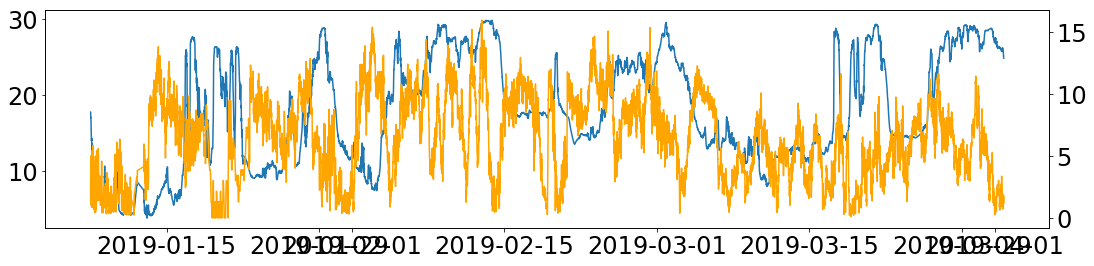

In [4]:
#the maximet timeseries is longer than the rbr timeseries, so crop them to the same length. 
sali = rbr.Salinity
winds = maximet.loc[slice(rbr.index[0], rbr.index[-1])].Speed
winddir = maximet.loc[slice(rbr.index[0], rbr.index[-1])].Direction

#however, the maximet timeseries also contains Nans, so we need to drop all the Nans from the dataset in order to do a cross-correlation
windNoNans = ~np.isnan(winds)
winds = winds[windNoNans]
winddir = winddir[windNoNans]
sali = sali[windNoNans]

fig, axx = plt.subplots(figsize=(18,4),facecolor='w')
axx.plot(sali)
par = axx.twinx()
par.plot(winds,'orange')

De-mean the vectors and perform a cross-correlation

Max Correlation of 0.401 occurs when the wind precedes the salinity signal by 78.5 hours


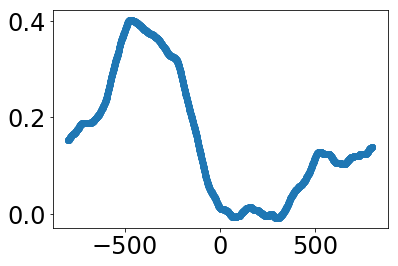

In [5]:
sali_demean = sali - sali.mean()
winds_demean = winds - winds.mean()

fig, axx = plt.subplots(facecolor='w')
[lags, corrs, h, b] = plt.xcorr(winds_demean, sali_demean, maxlags=800, usevlines=False, normed=True)
maxcorr = np.max(corrs)
maxlagind = lags[corrs==maxcorr].item()
maxlag = maxlagind/-6 #convert from 10-min segments into hours
print(f'Max Correlation of {np.round(maxcorr,3)} occurs when the wind precedes the salinity signal by {maxlag} hours')

Plot the timeseries shifted to overlap at the offset of maximum correlation

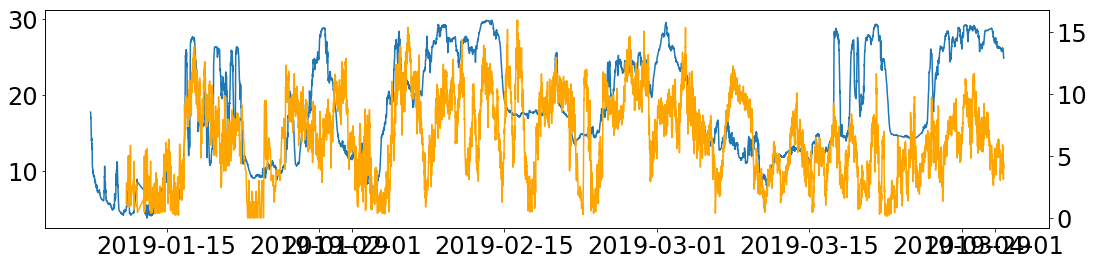

In [6]:
fig, axx = plt.subplots(figsize=(18,4),facecolor='w')
axx.plot(sali)
par = axx.twinx()
par.plot(winds.shift(periods=-maxlagind),'orange')

BUT we haven't accounted for the direction of the wind! What's amazing about this result is that the wind is coming from the east for the vast majority of the timeseries:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\windrose\windrose.py:457: MatplotlibDeprecationWarning: The poly_between function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  xs, ys = poly_between(angles, 0, val)


Text(0.5, 1.05, 'Wind Velocity Distribution')

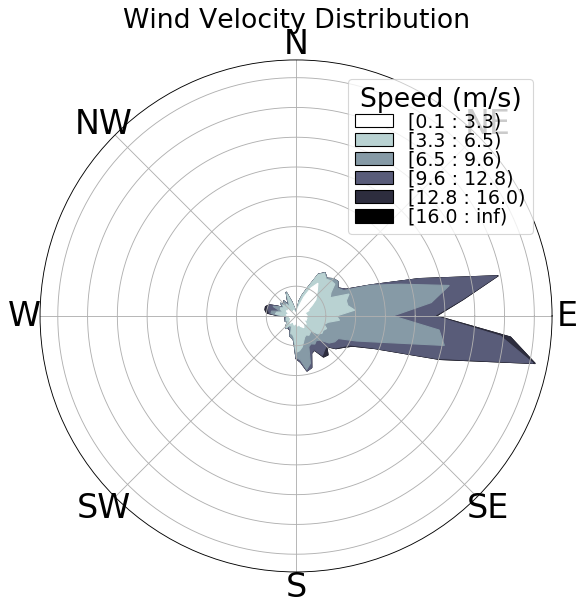

In [125]:
import windrose
h= windrose.plot_windrose(maximet.Direction,maximet.Speed,normed=True, kind='contourf',nsector=64,cmap=cm.bone_r)
h.set_yticklabels([])
h.set_xticklabels(['E','NE','N','NW','W','SW','S','SE'],fontdict={'fontsize':30})
h.legend(loc='best',labelspacing=0.001,title='Speed (m/s)',labels=[],fontsize=17,borderaxespad=1)
h.set_title('Wind Velocity Distribution',fontdict={'fontsize':24})


It would seem like Westerlies would be responsible for Salinity increases by pushing water towards the river channel, yet there are almost no westerly wind events and we still see the correlation between salinity and wind speed... ALSO, note the specific moment around February 20 in the timeseries in which a westerly wind burst appears to result in a corresponding spike in salinity (and decrease in temp). 

- enchanced mixing when wind and currents are opposed

 The lag of 3+ days in the correlation might mean that increased mixing is occuring in the Sound as a result of the wind stress, but that the wind is not actually all that responsible for moving water up and down the channel directly. Perhaps it is the river that predominantly sets the flow direction in the channel, and the winds are having an effect on the water properties by mixing up the oceanic end-member.

Let's try...
## Lag correlation between wind speed and stratification across the water column. 

Calculate stratification from the temperature string, and align the vectors.

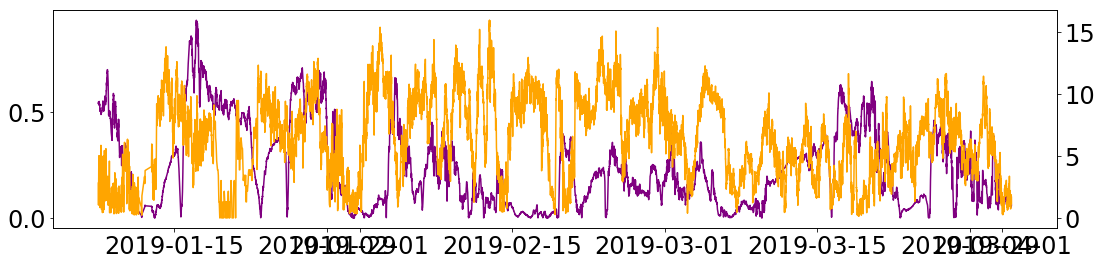

In [8]:
#temperature stratification = temp at max depth - temp at min depth
tStrat = np.abs(tempsXrInterp.isel(depth=-1) - tempsXrInterp.isel(depth=0)).to_pandas()
#crop winds to this length
winds = maximet.loc[slice(tStrat.index[0], tStrat.index[-1])].Speed
#winddir = maximet.loc[slice(tStrat.time.isel(time=0), tStrat.time.isel(time=-1))].Direction

#however, the maximet timeseries also contains Nans, so we need to drop all the Nans from the dataset in order to do a cross-correlation
windNoNans = ~np.isnan(winds)
winds = winds[windNoNans]
winddir = winddir[windNoNans]
tStrat = tStrat[windNoNans]

fig, axx = plt.subplots(figsize=(18,4),facecolor='w')
axx.plot(tStrat,'purple')
par = axx.twinx()
par.plot(winds,'orange')

One would expect that the winds cause a breakdown in stratification, and I can already tell from the timeseries that's unlikely to play out. 

De-mean the vectors and perform a cross-correlation

Max Correlation of -0.306 occurs when the wind precedes the temperature stratification signal by 160.66666666666666 hours


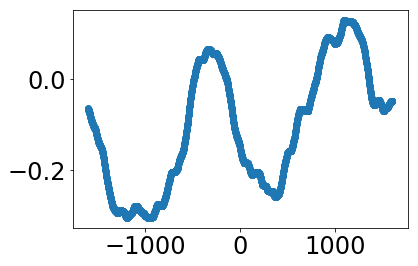

In [9]:
tStrat_demean = tStrat - tStrat.mean()
winds_demean = winds - winds.mean()

fig, axx = plt.subplots(facecolor='w')
[lags, corrs, h, b] = plt.xcorr(winds_demean, tStrat_demean, maxlags=1600, usevlines=False, normed=True)
maxcorr = np.min(corrs)
maxlagind = lags[corrs==maxcorr].item()
maxlag = maxlagind/-6 #convert from 10-min segments into hours
print(f'Max Correlation of {np.round(maxcorr,3)} occurs when the wind precedes the temperature stratification signal by {maxlag} hours')

Nothing good coming from this particular line of thought, I don't think. Probably because stratification at the measurement location is so tied to river outflow. 

## Lag correlation between bi-directional current and wind speed?

Given the strong correlation between salinity and both current and wind, this begs the question of cross-correlating these two signals.

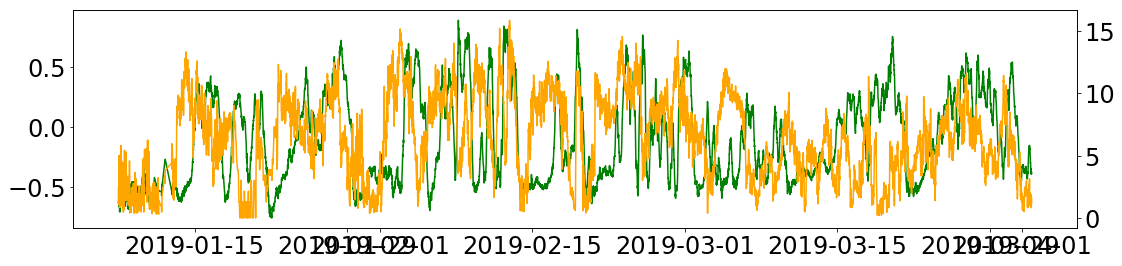

In [10]:
#resample winds to 15min periods to align with current data
winds = maximet.resample('15min').mean().Speed
curr = aqd2dir.mean(dim='bindepth').speed.to_pandas()

#need to crop to last date of aquadopp, and first date of winds
start = winds.index[1]
end = curr.index[-1]

curr = curr.loc[slice(start, end)]
winds = winds.loc[slice(start,end)]

#however, the maximet timeseries also contains Nans, so we need to drop all the Nans from the dataset in order to do a cross-correlation
windNoNans = ~np.isnan(winds)
winds = winds[windNoNans]
#winddir = winddir[windNoNans]
curr = curr[windNoNans]

fig, axx = plt.subplots(figsize=(18,4),facecolor='w')
axx.plot(curr,'green')
par = axx.twinx()
par.plot(winds,'orange')

Hmmm, the winds just might lead the current in a meaningful way here...

De-mean the vectors and perform a cross-correlation

Max Correlation of 0.34 occurs when the wind precedes the current signal by 20.0 hours


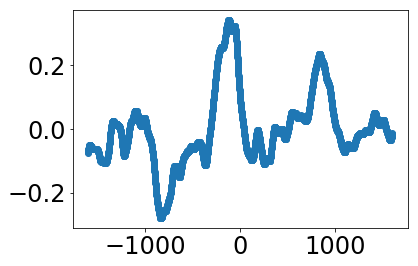

In [11]:
curr_demean = curr - curr.mean()
winds_demean = winds - winds.mean()

fig, axx = plt.subplots(facecolor='w')
[lags, corrs, h, b] = plt.xcorr(winds_demean, curr_demean, maxlags=1600, usevlines=False, normed=True)
maxcorr = np.max(corrs)
maxlagind = lags[corrs==maxcorr].item()
maxlag = maxlagind/-6 #convert from 10-min segments into hours
print(f'Max Correlation of {np.round(maxcorr,3)} occurs when the wind precedes the current signal by {maxlag} hours')

Plot the timeseries shifted to overlap at the offset of maximum correlation

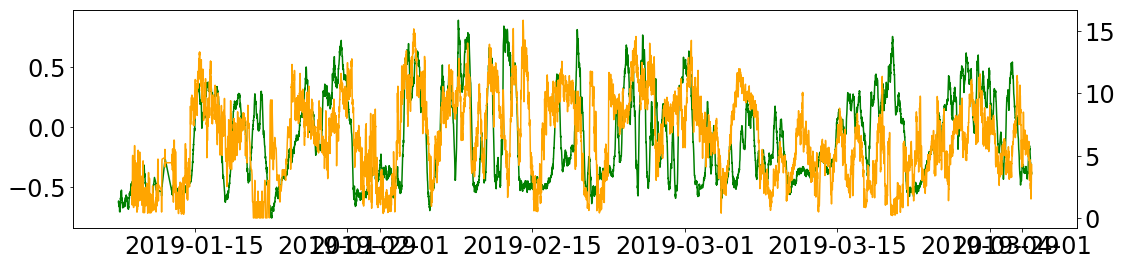

In [187]:
fig, axx = plt.subplots(figsize=(18,4),facecolor='w')
axx.plot(curr, 'green')
par = axx.twinx()
par.plot(winds.shift(periods=-maxlagind),'orange')

Again, given the fact that the wind is predominantly easterlies, I am pretty surprised that these line up so well, with times of river outflow corresponding to low wind speeds. I've double-checked that my wind directions are corrected to GPS North, and have reached out to Gill to make sure that I should be using the atmospheric convention for wind direction.

- Remove tidal signal and look at wind driving non-tidal current